# This notebook is for work on my (BD) CS480 research project, with the primary goal of Accurately Forecasting Tornado-forming Severe Storm Systems via Satellite Imagery and Machine Learning

## Preprocessing/Feature engineering

### GLM Data Cleaning

Todo:
- use np to generate new datasets from sets of datasets per time step of GLM data, so as to incorporate several steps at a time for more stream-like data
- add new dimension which is the output you wanna use (or make new dataset for that, and the above as well)

Going to use OCTANE-out file names to guide the process.

Use SatPy to coalesce the data for in between timesteps, then properly process and put together a custom dataset for it.

#### Experimenting

In [ ]:
# install glmtools
%pip install glmtools lmatools

ERROR: Could not find a version that satisfies the requirement lmatools (from versions: none)
ERROR: No matching distribution found for lmatools


Experimenting with SatPy GLM tools and GLMtools python package


In [ ]:
# learning to use glmtools and satpy's tools

In [ ]:
# glmtools install
!git clone https://github.com/deeplycloudy/glmtools.git

fatal: destination path 'glmtools' already exists and is not an empty directory.


##### [Converting fixed grid coordinates to longitude/latitude](https://github.com/deeplycloudy/glmtools/blob/master/docs/fixedgridguide.md)

(actually, [this](https://github.com/deeplycloudy/glmtools/blob/master/examples/glm_test_data_new_grid_dev.ipynb) is where the code here is from (for the most part, at least)

In [ ]:
import os
import numpy as np
import ipywidgets as widgets
from glmtools.io.glm import GLMDataset
from datetime import datetime, timedelta

ModuleNotFoundError: ignored

In [ ]:
from glmtools.test.common import get_sample_data_path

sample_path = get_sample_data_path()
samples = [
    "OR_GLM-L2-LCFA_G16_s20181830433000_e20181830433200_c20181830433231.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433200_e20181830433400_c20181830433424.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433400_e20181830434000_c20181830434029.nc",
]
samples = [os.path.join(sample_path, s) for s in samples]

In [ ]:
import subprocess
import os, glob
import tempfile
tmpdir = tempfile.TemporaryDirectory()

import glmtools
from glmtools.test.common import get_sample_data_path
# glmtools_path = os.path.abspath(glmtools.__path__[0])
glmtools_path = os.path.abspath('.')

# Set the start time and duration
startdate = datetime(2018, 7, 2, 4, 30)
duration = timedelta(0, 60*5)
enddate = startdate+duration

cmd = "python {0}/../examples/grid/make_GLM_grids.py -o {1}"
cmd += " --fixed_grid --split_events --goes_position=east --goes_sector=meso"
cmd += " --ctr_lat=33.5 --ctr_lon=-101.5 --dx=2.0 --dy=2.0"
cmd += " --start={3} --end={4} {2}"

cmd = cmd.format(glmtools_path, tmpdir.name, ' '.join(samples),
                startdate.isoformat(), enddate.isoformat())
# print (cmd)
out_bytes = subprocess.check_output(cmd.split())
# print(out_bytes.decode('utf-8'))

grid_dir_base = tmpdir.name
nc_files = glob.glob(os.path.join(grid_dir_base, startdate.strftime('%Y/%b/%d'),'*.nc'))
# print(nc_files)

In [ ]:
from lmatools.grid.grid_collection import LMAgridFileCollection

# 056 is 2 km resolution
res = '056'

dtdx_base = '{0}_1src_{1}urad-dx'.format(int(duration.total_seconds()), res)
glm_init_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_flash_init.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_fed_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_flash_extent.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_ed_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_source.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_energy_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_total_energy.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_foot_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_footprint.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_grinit_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_init.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_ged_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_extent.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_grfoot_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_group_area.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))
glm_minarea_files = glob.glob(os.path.join(grid_dir_base, '{0}/*_{1}_flash_area_min.nc'.format(startdate.strftime('%Y/%b/%d'), dtdx_base)))



display_params = {}
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm, Normalize
glm_cmap = get_cmap('viridis')
glm_cmap._init()
alphas = np.linspace(1.0, 1.0, glm_cmap.N+3)
glm_cmap._lut[:,-1] = alphas
glm_cmap._lut[0,-1] = 0.0

glm_flctr_grids = LMAgridFileCollection(glm_init_files, 'flash_centroid_density',
                                        x_name='x', y_name='y', t_name='time')
display_params[glm_flctr_grids] = {
    'product_label':"GLM Flash Centroid Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=5),
    'file_tag':'flash_init'
}

glm_fed_grids = LMAgridFileCollection(glm_fed_files, 'flash_extent_density',
                                      x_name='x', y_name='y', t_name='time')
display_params[glm_fed_grids] = {
    'product_label':"GLM Flash Extent Density (count)",
    'glm_norm':LogNorm(vmin=0.9, vmax=48),
    'file_tag':'flash_extent',
}

glm_ged_grids = LMAgridFileCollection(glm_ged_files, 'group_extent_density',
                                      x_name='x', y_name='y', t_name='time')
display_params[glm_ged_grids] = {
    'product_label':"GLM Group Extent Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=200),
    'file_tag':'group_extent',
}

glm_ed_grids = LMAgridFileCollection(glm_ed_files, 'event_density',
                                     x_name='x', y_name='y', t_name='time')
display_params[glm_ed_grids] = {
    'product_label':"GLM Event Density (count)",
    'glm_norm':Normalize(vmin=0, vmax=200),
    'file_tag':'event_density',
}

glm_energy_grids = LMAgridFileCollection(glm_energy_files, 'total_energy',
                                         x_name='x', y_name='y', t_name='time')
display_params[glm_energy_grids] = {
    'product_label':"GLM Total Energy (J)",
    'glm_norm':LogNorm(vmin=1e-18, vmax=1e-12),
    'file_tag':'total_energy'
}
# display_params[glm_energy_grids]['glm_cmap'].set_bad('w',0)

glm_flarea_grids = LMAgridFileCollection(glm_foot_files, 'average_flash_area', x_name='x', y_name='y', t_name='time')
display_params[glm_flarea_grids] = {
    'product_label':"GLM Average Flash Area (km^2)",
    'glm_norm':LogNorm(vmin=32, vmax=.5e4),
    'file_tag':'flash_area'
}

glm_grarea_grids = LMAgridFileCollection(glm_grfoot_files, 'average_group_area', x_name='x', y_name='y', t_name='time')
display_params[glm_grarea_grids] = {
    'product_label':"GLM Average Group Area (km^2)",
    'glm_norm':LogNorm(vmin=32, vmax=.5e4),
    'file_tag':'group_area'
}


glm_minflarea_grids = LMAgridFileCollection(glm_minarea_files, 'minimum_flash_area', x_name='x', y_name='y', t_name='time')
display_params[glm_minflarea_grids] = {
    'product_label':"GLM Minimum Flash Area (km^2)",
    'glm_norm':LogNorm(vmin=32, vmax=.5e4),
    'file_tag':'flash_area_min'
}

In [ ]:
# Plot this grid
# glm_grids = glm_fed_grids
# glm_grids = glm_flarea_grids
glm_grids = glm_minflarea_grids


# Grab the needed paramters for plotting
glm_norm = display_params[glm_grids]['glm_norm']
product_label = display_params[glm_grids]['product_label']
file_tag = display_params[glm_grids]['file_tag']

In [ ]:
print(glm_grids._filenames)

In [ ]:
label_string = """
{1} (max {0:3.0f})"""

%matplotlib notebook
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

glm_times = glm_grids.times
glm_times.sort()

geoproj = ccrs.Geodetic()

def plot(t, fig):

    fig.clf()
    t_glm = t['new']
    glmx, glmy, glm, glm_nc= glm_grids.data_for_time(t_glm, return_nc=True)
    proj_var = glm_nc.variables['goes_imager_projection']
    x = glmx * proj_var.perspective_point_height
    y = glmy * proj_var.perspective_point_height

    glm_xlim = x.min(), x.max()
    glm_ylim = y.min(), y.max()

#     Use a masked array instead of messing with colormap to get transparency
#     glm = np.ma.array(glm, mask=(glm == 0))
#     glm_alpha = .5 + glm_norm(glm)*0.5

    state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                    name='admin_1_states_provinces_lakes',
                                                    scale='50m', facecolor='none')
    globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
    proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                              satellite_height=proj_var.perspective_point_height, globe=globe)
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    glm_img = ax.imshow(glm, extent=(x.min(), x.max(),
                           y.min(), y.max()),
#                            transform = ccrs.PlateCarree(),
                           cmap=glm_cmap, interpolation='nearest',
                           norm=glm_norm)#, alpha=0.8)
    ax.coastlines('10m', color='red')
    ax.add_feature(state_boundaries, edgecolor='red')

    # Match the GLM grid limits, in fixed grid space
    ax.set_xlim(glm_xlim)
    ax.set_ylim(glm_ylim)

    # Set a lat/lon box directly
#     ax.set_extent([-103, -99.5, 31.0, 34.0])

    limits = ax.axis()
    ax.text(limits[0]+.02*(limits[1]-limits[0]), limits[2]+.02*(limits[3]-limits[2]),
        t_glm.isoformat().replace('T', ' ')+' UTC'+
        label_string.format(glm.max(), product_label),
#             transform = proj,
        color=(0.3, 0.0, 0.0))


    cbar = plt.colorbar(glm_img, orientation='vertical')
    # Make the colorbar position match the height of the Cartopy axes
    # Have to draw to force layout so that the ax position is correct
    fig.canvas.draw()
    posn = ax.get_position()
    cbar.ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])



fig = plt.figure(figsize=(10,10))

def resize_colorbar(event):
    ax, cbar_ax = fig.axes[0], fig.axes[1]
    posn = ax.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])
fig.canvas.mpl_connect('resize_event', resize_colorbar)

from functools import partial
plot = partial(plot, fig=fig)

from ipywidgets import widgets
time_slider = widgets.SelectionSlider(options=glm_times)
time_slider.observe(plot, 'value')
display(time_slider)
time_slider.value = time_slider.options[3]

Image of each frame:

In [ ]:
# print(grid_dir_base)
# print(file_tag)
images_out = []
for option in time_slider.options[:]:
    time_slider.value = option
    resize_colorbar('foo')
    outfile=grid_dir_base + 'GLM_{1}_{0}.png'.format(option, file_tag)
    outfile = outfile.replace(' ', '_')
    outfile = outfile.replace(':', '')
    images_out.append(outfile)
    fig.savefig(outfile)
# print(images_out)

In [ ]:
from IPython.display import Image
Image(images_out[3])

#### Automation

In [ ]:
# 500 x 500 array/DataArray
# GLM lightning intensity * lightning density

In [ ]:
# if first_amv_time < GLM_nc_time < last_amv_time, add it to the scene (one timestep at a time(?))
amv_files = os.listdir('/content/OCTANE-out')
glm_files = os.listdir('/content/GLM-raw')
for amv_file in amv_files:
  first_amv_time = int(amv_file.split('-')[1])
  second_amv_time = int(amv_file.split('-')[2][0:14])
  # not very efficient, but it works for now
  for glm_file in glm_files:
    curr_glm_time = int(glm_file.split('_')[3][1:])
    if curr_glm_time >= first_amv_time and curr_glm_time <= second_amv_time:
      # do satpy thing
      curr_
    else:
      continue


In [ ]:
!unzip GLM_test-set-5.zip

Streaming output truncated to the last 5000 lines.
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931112000_e20220931112200_c20220931112226.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931112200_e20220931112400_c20220931112417.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931112400_e20220931113000_c20220931113020.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931113000_e20220931113200_c20220931113217.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931113200_e20220931113400_c20220931113419.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931113400_e20220931114000_c20220931114018.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931114000_e20220931114200_c20220931114218.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931114200_e20220931114400_c20220931114421.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s20220931114400_e20220931115000_c20220931115016.nc  
  inflating: GLM_test-set-5/OR_GLM-L2-LCFA_G16_s2

### ABI Data Cleaning

Important resource:
- [Preprocessing steps, as well as beginners guide to using ABI/GOES data](https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf)

#### GOES-R Python visualization and data manipulation
Utilizing the link above as a resource

##### Visualizing raw netCDF4 data from GOES ABI:

In [ ]:
%pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.5 MB/s eta 0:00:00


In [ ]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
# import dataset to be visualized
test_file_path = '/content/OCTANE-out/amv-multiband-test.ncoutfile.nc'#/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_3/OR_ABI-L1b-RadM2-M6C08_G16_s20220962010549_e20220962011007_c20220962011056.nc'
nc_ds = nc.Dataset(test_file_path)
store = xr.backends.NetCDF4DataStore(nc_ds)
test_ds = xr.open_dataset(store)

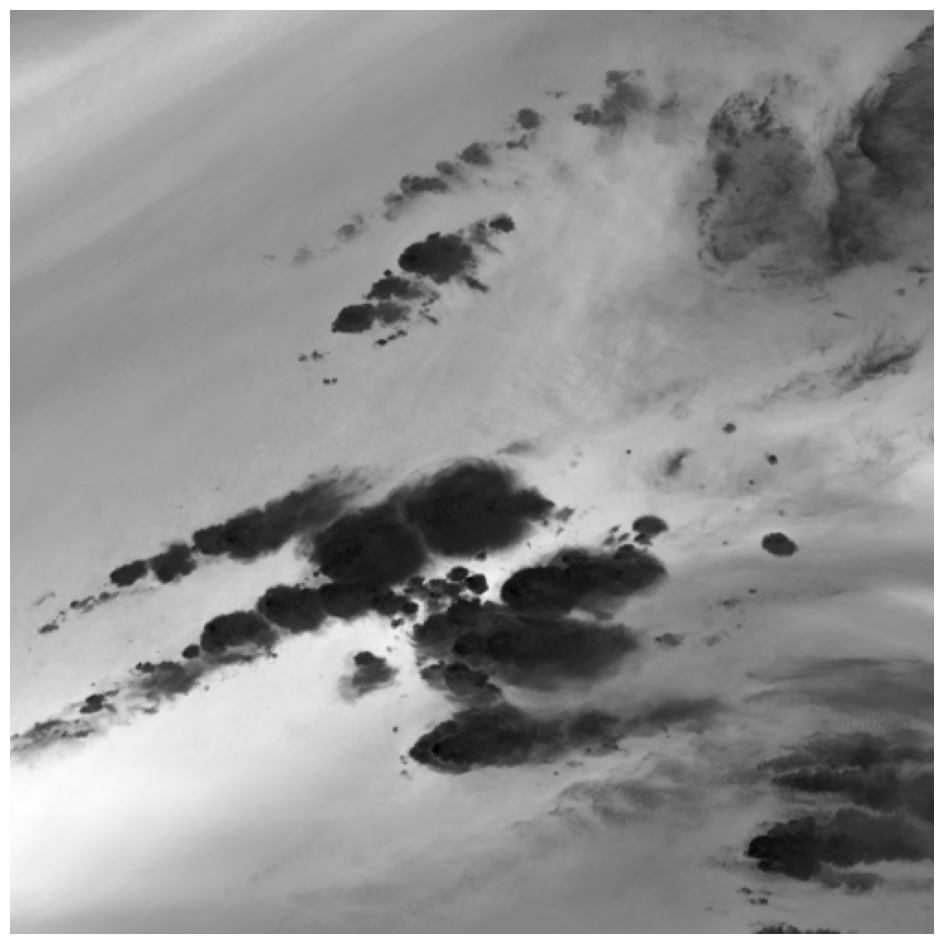

In [ ]:
# visualize nc dataset
fig = plt.figure(figsize = (12, 12))
plt.imshow(test_ds.Rad, cmap = 'gray')
plt.axis('off')
plt.savefig('ABI_plt_test.png', dpi = 300, facecolor = 'w', edgecolor = 'w')

#### SatPy:

In [ ]:
# install packages
%pip install satpy
%pip install rasterio
%pip install pyresample
%pip install netcdf4==1.5.8 # newest build breaks satpy

In [ ]:
# set up dask
import dask
dask.config.set(num_workers=8)

In [ ]:
# imports
import satpy as sat
import pandas as pd
import xarray as xr
import netCDF4 as nc
from glob import glob

In [ ]:
# example of basic satpy workflow
# reader for ABI: 'abi_l1b'
# reader for GLM: 'glm_l2'
#scn = sat.Scene(reader='abi_l1b', filenames=glob('/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220403_00/*.nc'))
#scn.load(['C01', 'C02', 'C03'], generate=False)
#new_scn = scn.resample(resampler='native')

In [ ]:
# save resampled dataset(s) in local file system
# currently having issues, may be due to version control issues; not a priority for the moment, will get to later
#new_scn.save_datasets(base_dir='tmp')

Note to self: [get back to this once finished with AMVs](https://github.com/pytroll/tutorial-satpy-half-day/blob/main/notebooks/02_reading.ipynb)

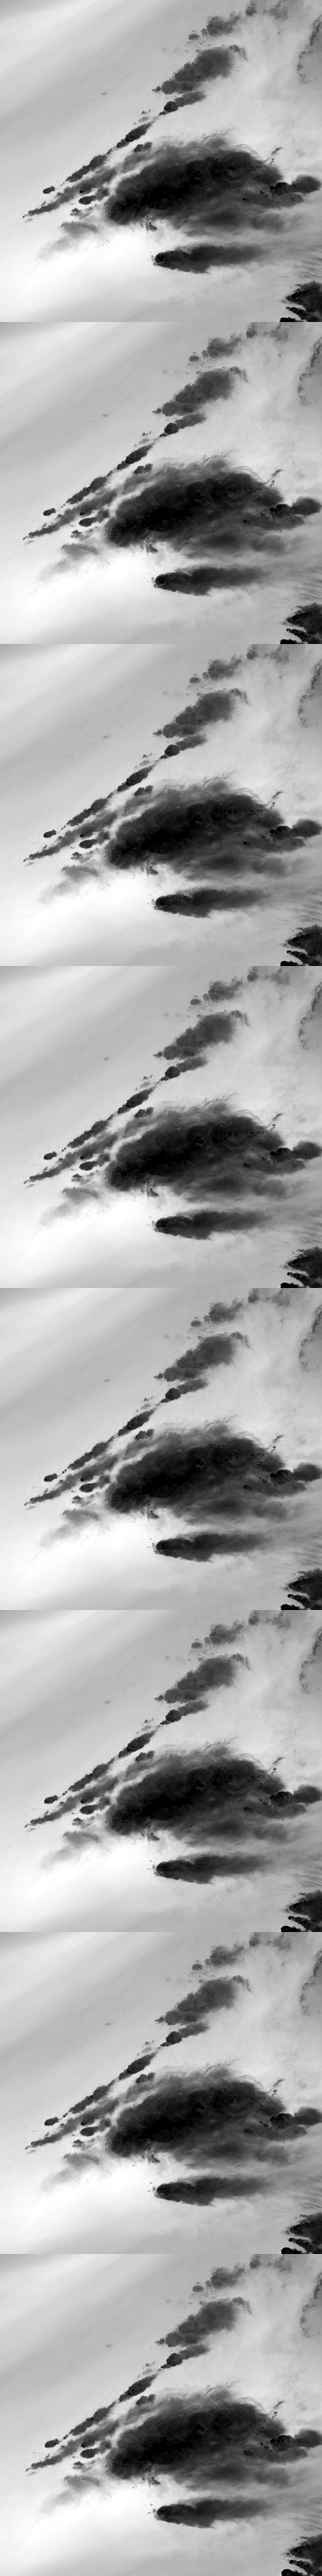

/usr/local/lib/python3.10/dist-packages/satpy/resample.py:448: UserWarning: Upgrade 'pyresample' for a more accurate default 'radius_of_influence'.
  cache_id = self.precompute(cache_dir=cache_dir, **kwargs)


AssertionError: ignored

In [ ]:
# testing different resampling algorithms for hopes of scanline noise reduction

# load and show raw abi data
scn = sat.Scene(reader = 'abi_l1b', filenames = glob('/content/ABI-test-data/*.nc'))
scn.load(['C08'])
scn.show('C08')

# resample and show
new_scn = scn.resample(resampler = 'nearest')
new_scn.show('C08')

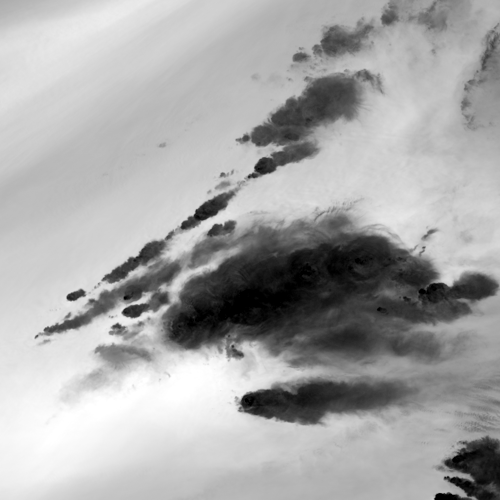

/usr/local/lib/python3.10/dist-packages/satpy/writers/cf_writer.py:1093: UserWarning: Backend version mismatch. Compression might fail or be ignored silently. Recommended: All versions below or above netCDF4-1.6.0/libnetcdf-4.9.0/xarray-2022.12.0.
  return self.save_datasets([dataset], filename, **kwargs)
<ipython-input-98-3a4a65acbd4b>:28: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  test_ds.to_netcdf('./test_ds.nc')
<ipython-input-98-3a4a65acbd4b>:28: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  test_ds.to_netcdf('./test_ds.nc')
<ipython-input-98-3a4a65acbd4b>:29: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  tds.to_netcdf('./test_tds.nc')
<ipython-input-98-3a4a65acbd4b>:29: SerializationWarning: saving variable x with floating point data as an i

In [ ]:
# test the saving dataset functionality

#scn.save_datasets(writer = 'cf', datasets = ['C08'], filename = 'test_satpy_out.nc')

# run thru satpy scn, for every pixel in Rad, set Rad to scn.C08
# load data file
file_name_path = '/content/ABI-test-data/OR_ABI-L1b-RadM2-M6C08_G16_s20220962200549_e20220962201007_c20220962201054.nc'
nc_ds = nc.Dataset(file_name_path)
store = xr.backends.NetCDF4DataStore(nc_ds)
test_ds = xr.open_dataset(store)

# load and show raw abi data
scn = sat.Scene(reader = 'abi_l1b', filenames = glob(file_name_path))
scn.load(['C08'])
scn.show('C08')
scn.save_dataset('C08', 'satpy_test.nc')

# set Rad to satpy cleaned version
tds = test_ds
tds['Rad'].data = scn['C08']


# plot raw data
plt.imshow(test_ds['Rad'])
plt.imshow(tds['Rad'].data)

# save to new .nc files
test_ds.to_netcdf('./test_ds.nc')
tds.to_netcdf('./test_tds.nc')


# unload data
#test_ds.close()
#tds.close()
#store.close()
#nc_ds.close()
#scn.unload()

In [ ]:
# gen rgb composites, compare results
#plt.imshow(test_ds['Rad'].data)
gen_rgb_composites_for_dir('test_tds.nc')


In [ ]:
!mv /content/.ipynb_checkpoints/OR* /content/ABI-raw

#### SatPy automation

Turns out this is completely unnecessary.

The main issue (as to why the data was so messed up as RGB composites) was because of how I was preprocessing/normalizing the data before generating the composites. Now that that's fixed, everything seems fine now, haha.

It appears that SatPy automatically implements appropriate data cleaning operations. It may thus be suitable to run each timestep through SatPy before sending to OCTANE and the rest of the pipeline. This should also be done for GLM data.

In [ ]:
# install SatPy and abi dependencies
%pip install satpy
%pip install netcdf4==1.5.8

In [ ]:
# set up dask
import dask
dask.config.set(num_workers=8)

In [ ]:
# imports
import satpy as sat
import pandas as pd
import xarray as xr
from glob import glob
import os

In [ ]:
# clean all ABI files in directory via satpy
def clean_abi_satpy(dir_path):
  filenames = os.listdir(dir_path)
  for file in filenames:

    # load data file
    raw_ds = nc.Dataset(file)
    stored = xr.backends.NetCDF4DataStore(raw_ds)
    curr_ds = xr.open_dataset(stored)


    # clean with SatPy
    curr_scn = sat.Scene(reader = 'abi_l1b', filenames = glob(file))


    # simplify closing dataset
    def close_ds():
      raw_ds.close()
      curr_ds.close()
      stored.close()
      curr_scn.unload()

    close_ds()


#### Cleaning the data (defunct)

Plan:
- Start off by doing every third timestep as a baseline
- If `missing_pixel_count` is equal to or greater than `mpc_threshold` (try starting with 0.10), then move this timestep to a different folder, and move on to the next time step as if it was the current one.
- If `flag_values(x, y)` is 2B or higher, use nearest neighbors to get nearby average, and set `Rad(x, y)` to the NN output
- If `flag_values(x, y)` is 1B, try as follows: set `Rad(x, y)` to `(curr_rad * cr_threshold) + (neighboring_eight_pixels * (1 - cr_threshold) / 8)`.

In [ ]:
# install netCDF4
%pip install netCDF4

In [ ]:
# imports
import netCDF4 as nc
import numpy as np
import xarray as xr

##### Load current timestep `.nc` file

##### Automation

In [ ]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import os

In [ ]:
# clean abi data in directory
def clean_abi_raw(dir_path, mpc_threshold = 0.1, use_nn = True, nn_threshold = 0.75):
  # get list of file names in directory
  file_list = os.listdir(dir_path)

  DQF_vals = ['2B', '3B', '4B', '5B']   # 4 of 6 possible values of Data Quality Flags
  # loop through coordinates and (if necessary) apply nearest neighbors algorithm to smooth out scanlines
  def apply_nn(cds):
    placeholder = 0

  # loop through all files
  for file in file_list:
    # load data file
    raw_ds = nc.Dataset(file)
    stored = xr.backends.NetCDF4DataStore(raw_ds)
    curr_ds = xr.open_dataset(stored)

    # simplify closing dataset
    def close_ds():
      raw_ds.close()
      curr_ds.close()
      stored.close()

    # if missing too many pixels, skip file
    if curr_ds.missing_pixel_count >= (250000 * mpc_threshold):  # if greater than 10% of total "pixels" (250,000)
      close_ds()
      continue

    if use_nn:
      cds = curr_ds
      ads = cds['Rad']
      for y in cds['y']
        for x in cds['x']
          if cds['DQF'] in DQF_vals:
            # nearest neighbors
            ads = cds['Rad'](y = y, x = x)
      # set cds to newly made dataset
      cds['Rad'] = ads


    # move current file to cleaned folder
    os.system('cp {} /content/abi_clean_all'.format(file))

    # close dataset
    close_ds()



In [ ]:
#testing
import matplotlib.pyplot as plt
from datetime import datetime

# load data from file
raw_abi_path = '/content/abi_raw_test/OR_ABI-L1b-RadM2-M6C08_G16_s20220961000549_e20220961001006_c20220961001061.nc'
ncds = nc.Dataset(raw_abi_path)
store = xr.backends.NetCDF4DataStore(ncds)
ds = xr.open_dataset(store)
# plot raw data
plt.imshow(ds['Rad'])

# run cleaner
clean_abi_raw('./abi_raw_test/')

# plot cleaned data
clean_abi_path = '/content/abi_clean_test/OR_ABI-L1b-RadM2-M6C08_G16_s20220961000549_e20220961001006_c20220961001061.nc'
ncds = nc.Dataset(clean_abi_path)
storec = xr.backends.NetCDF4DataStore(ncds)
dsc = xr.open_dataset(storec)
# plot cleaned data
plt.imshow(dsc['Rad'])

SyntaxError: ignored

### OCTANE setup (for generating Atmospheric Motion Vectors)

#### Initialization:

Important notes on OCTANE:
- Remember to place it between the two timesteps from which the AMVs are derived in relation to the timeseries (i.e. time_of_amv = time_of_timestep_2 - time_of_timestep_1)
- Apparently it was intended for use on cloud- and water-vapor-drift motions (perfect for your use case), so make sure to utilize those three bands from the ABI (8: upper-, 9: mid-, and 10: lower-level water vapor) (as well as maybe the cloud-top phase (11))

In [ ]:
import os
import xarray as xr

base_dir = os.getcwd()  # to come back to home folder after

In [ ]:
# check for cuda driver
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
%pip install netcdf4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.1 MB/s eta 0:00:00


In [ ]:
# install netcdf-cxx4 (necessary for OCTANE)
!apt install libnetcdf-c++4-dev
!apt install netcdf-bin netcdf-doc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libnetcdf-c++4-1
Suggested packages:
  netcdf-bin netcdf-doc
The following NEW packages will be installed:
  libnetcdf-c++4-1 libnetcdf-c++4-dev
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 190 kB of archives.
After this operation, 1,371 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libnetcdf-c++4-1 amd64 4.3.1-3build1 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libnetcdf-c++4-dev amd64 4.3.1-3build1 [110 kB]
Fetched 190 kB in 2s (125 kB/s)
Selecting previously unselected package libnetcdf-c++4-1.
(Reading database ... 129824 files and directories currently installed.)
Preparing to unpack .../libnetcdf-c++4-1_4.3.1-3build1_amd64.deb ...
Unpacking libnetcdf-c++4-1 (4.3.1-3build1) ...
Selecting previously unselected package libn

In [ ]:
# no longer needed after building it into the OCTANE directory (modified)
# keeping this around as a reference, just in case

# install cuda samples (used by OCTANE)
#os.chdir('/usr/local/cuda-11.8')
#!rm -r cuda-samples
#!git clone https://github.com/NVIDIA/cuda-samples.git # get cuda samples from the git repo
# move files to proper locations
#!mv cuda-samples/bin/* ./bin/
#!mv cuda-samples/Common/* ./common/
#!mv cuda-samples/Samples/* ./samples/
#!mv cuda-samples/* .

In [ ]:
!ncxx4-config --includedir

/usr/include


In [ ]:
# install octane
import os

# change working directory to OCTANE-master to make and build the program
os.chdir('/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-master/src')  # OCTANE home dir

# make OCTANE program
!make

g++ -o ../build/octane ../build/oct_variational_optical_flow.o ../build/oct_util.o ../build/oct_bicubic.o ../build/oct_zoom.o ../build/oct_gaussian.o ../build/oct_normalize_geo.o ../build/oct_fileread.o ../build/oct_filewrite.o ../build/oct_srsal_cuda.o ../build/oct_patch_match_optical_flow.o ../build/oct_binterp.o ../build/oct_navcal_cuda.o ../build/oct_polar_navcal_cuda.o ../build/oct_merc_navcal_cuda.o ../build/oct_pix2uv_cuda.o ../build/oct_optical_flow.o ../build/oct_interp.o ../build/main.o ../build/jCGlink.o -g -O3 -I /usr/include -I /usr/include -I ../include  -L /usr/lib -lnetcdf -L /usr/lib -lnetcdf_c++4 -L/usr/local/cuda-11.8/lib64 -lcudart -lcudadevrt 


In [ ]:
os.chdir('../build')
!chmod +x ./octane

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/OCTANE-master/build/octane /content/
os.chdir('/content')
!./octane

Beginning variational dense optical flow...
Optical Flow Toolkit for Atmospheric aNd Earth sciences (OCTANE)
Author: Jason Apke
Contact: jason.apke@colostate.edu
input flags:

-i1 <filename>, -i2 <filename> are the GOES-R file netcdf full paths, i1 is the first image, i2 is the second

-i1cth <filename>, -i2cth <filename> are optional paths to cloud top height netcdfs 

-nncth instead of default bilinear interpolation, remap the CTH grids with nearest neighbor 

-o <directory> writes the file to the designated directory, include slash at the end (default is ./) 

-pd forces OCTANE to return unnavigated pixel displacements 

-srsal has OCTANE return bilinearly smoothed optical flow output (useful for computing cloud-top divergence) 

-Polar use this flag to ingest polar-orthonormal grid images instead of GOES projections (used for sea-ice tracking)

-Merc use this flag to injest mercator grid images instead of GOES projections (definition) 

-ahi (deprecated) use when reading netcdfs co

In [ ]:
# generate AMVs using custom script gen_octane.sh

# copy script to base directory
!cp /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/gen_octane.sh /content/
os.chdir('/content/')
# allow execution as script
!chmod +x gen_octane.sh


#### Now for experimentation:

In [ ]:
# ensure OCTANE is working properly
os.chdir('/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-master/build')
!./octane

Beginning variational dense optical flow...
Optical Flow Toolkit for Atmospheric aNd Earth sciences (OCTANE)
Author: Jason Apke
Contact: jason.apke@colostate.edu
input flags:

-i1 <filename>, -i2 <filename> are the GOES-R file netcdf full paths, i1 is the first image, i2 is the second

-i1cth <filename>, -i2cth <filename> are optional paths to cloud top height netcdfs 

-nncth instead of default bilinear interpolation, remap the CTH grids with nearest neighbor 

-o <directory> writes the file to the designated directory, include slash at the end (default is ./) 

-pd forces OCTANE to return unnavigated pixel displacements 

-srsal has OCTANE return bilinearly smoothed optical flow output (useful for computing cloud-top divergence) 

-Polar use this flag to ingest polar-orthonormal grid images instead of GOES projections (used for sea-ice tracking)

-Merc use this flag to injest mercator grid images instead of GOES projections (definition) 

-ahi (deprecated) use when reading netcdfs co

In [ ]:
# testing multiple bands
!./octane -alpha 5 -lambda 1 -i1 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C08_G16_s20220962000549_e20220962001007_c20220962001054.nc' -i2 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C08_G16_s20220962004549_e20220962005007_c20220962005051.nc' -ic21 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C09_G16_s20220962000549_e20220962001012_c20220962001058.nc' -ic22 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C09_G16_s20220962004549_e20220962005012_c20220962005057.nc' -o '/content/OCTANE-out/amv-multiband-test.nc'
# -i1cth '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C11_G16_s20220962000549_e20220962001007_c20220962001053.nc' -i2cth '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C11_G16_s20220962004549_e20220962005007_c20220962005054.nc'

Beginning variational dense optical flow...
Here are the file names being used: 
File 1 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C08_G16_s20220962000549_e20220962001007_c20220962001054.nc
File 2 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_4/OR_ABI-L1b-RadM2-M6C08_G16_s20220962004549_e20220962005007_c20220962005051.nc
Number of Blocks per SM (there are 20 SMs) 4
GOESWRITE failure
/content/OCTANE-out/amv-multiband-test.ncoutfile.nc written
OCTANE completed, exiting


In [ ]:
# OCTANE confirmed working!

In [ ]:
# test out OCTANE on some .nc files
#!./octane -alpha -lambda -ir -i1 /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/data/ABI/20220403_00/OR_ABI-L1b-RadM1-M6C01_G16_s20220930000278_e20220930000335_c20220930000384.nc -i2 /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/data/ABI/20220403_00/OR_ABI-L1b-RadM1-M6C01_G16_s20220930001249_e20220930001306_c20220930001340.nc -o /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/OCTANE-out/

Beginning variational dense optical flow...
Here are the file names being used: 
File 1 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220403_00/OR_ABI-L1b-RadM1-M6C01_G16_s20220930000278_e20220930000335_c20220930000384.nc
File 2 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220403_00/OR_ABI-L1b-RadM1-M6C01_G16_s20220930001249_e20220930001306_c20220930001340.nc
Number of Blocks per SM (there are 20 SMs) 4
/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-out/outfile.nc written
OCTANE completed, exiting


In [ ]:
# not used anymore, kept around as a reference, just in case

# generate AMVs for
#!./octane -alpha 5 -lambda 1 -i1 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C08_G16_s20220961700549_e20220961701007_c20220961701053.nc' -i2 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C08_G16_s20220961701549_e20220961702007_c20220961702052.nc' -o '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-out/output1.nc'
# -ic21 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C09_G16_s20220961700549_e20220961701012_c20220961701057.nc' -ic22 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C09_G16_s20220961701549_e20220961702012_c20220961702049.nc' -ic31 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C10_G16_s20220961700549_e20220961701018_c20220961701052.nc' -ic32 '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C10_G16_s20220961701549_e20220961702018_c20220961702052.nc'  -o '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-out/output.nc'

Beginning variational dense optical flow...
Here are the file names being used: 
File 1 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C08_G16_s20220961700549*.nc
File 2 : /content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/20220406/testing-data/region-2/OR_ABI-L1b-RadM2-M6C08_G16_s20220961701549*.nc
OCT_GOESREAD FAILURE, CHECK THAT ALL VARIABLES AND ATTS EXIST


In [ ]:
# testing
#!path="/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/data/ABI/test_set_3/" && filename="OR_ABI-L1b*" && echo $filename && find "$path" -name "$filename"
!cd /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/data/ABI/test_set_3/ && find . -name OR_ABI-L1b-RadM2-M6C08_G16_s20220961822249*.nc

In [ ]:
# generate AMVs with gen_octane.sh
!./gen_octane.sh
!./gen_octane.sh 08 20220962000549 20220962004549
!./gen_octane.sh 08 20220962004549 20220962008549
!./gen_octane.sh 08 20220962004549 20220962012549
!./gen_octane.sh 08 20220962012549 20220962016549
!./gen_octane.sh 08 20220962016549 20220962020549
!./gen_octane.sh 08 20220962020549 20220962024549
!./gen_octane.sh 08 20220962024549 20220962028549
!./gen_octane.sh 08 20220962028549 20220962032549
!./gen_octane.sh 08 20220962032549 20220962036549

gen_octane.sh

Bri D'Urso 2023

How to use:
  Example:
    ./gen_octane.sh 09 20220961700549 20220961701549
         where "09" is the GOES ABI channel,
         "20220961700549" is the first timestep (by filename)
         and "20220961701549" is the second timestep (by filename)

  Argument 1:
    GOES ABI channel (two digit number)
    Examples:
      09
      10
      11
  Argument 2:
    First GOES ABI timestep (by filename, e.g. from s20220961700549)
    Examples:
      20220961700549
      20220961701549
      20220961702549
  Argument 3:
    Second GOES ABI timestep (by filename, e.g. from s20220961701549)
    Examples:
      20220961701549
      20220961702549
      20220961703549
  Argument 4:
    (optional) Data home directory
    Examples:
      /home/user/doc/data/dataset
      ./data/here
      /content/drive/MyDrive/data/

  Examples:
    ./gen_octane.sh 09 20220961700549 20220961701549
    ./gen_octane.sh 11 20220961702549 20220961703549 /data/folder
    ./gen_octane.sh

In [ ]:
# load OCTANE output file as xarray
octane_out_file_path = '/content/OCTANE-out/amvout_07-20220961700549-20220961701549.ncoutfile.nc'
octane_test_xr = xr.open_dataset(octane_out_file_path)
octane_test_xr

<xarray.Dataset>
Dimensions:                 (x: 500, y: 500)
Coordinates:
  * x                       (x) float64 -0.03693 -0.03688 ... -0.008988
  * y                       (y) float64 0.1103 0.1102 0.1102 ... 0.0824 0.08235
Data variables: (12/13)
    t                       datetime64[ns] ...
    U                       (y, x) float32 ...
    V                       (y, x) float32 ...
    U_raw                   (y, x) float32 ...
    V_raw                   (y, x) float32 ...
    Rad                     (y, x) float64 ...
    ...                      ...
    optical_flow_settings   int32 ...
    planck_fk1              float32 ...
    planck_fk2              float32 ...
    planck_bc1              float32 ...
    planck_bc2              float32 ...
    kappa0                  float32 ...

In [ ]:
os.chdir('/content/')

In [ ]:
# sweet! everything seems to be working just fine.
# now to figure out how I'm gonna implement/visualize all this...
#   maybe see if you can manipulate the output to look enough like "raw" ABI data to be interpreted
#   in the same way via satpy...?

Idea for visualizing with SatPy alongside ABI imagery:

To visualize with SatPy, one idea for doing so could be to simply pair each coordinate (from OCTANE) with its raw ABI data equivalent, and then plot them where said raw ABI data point is on the SatPy output.
- Steps to do so:
 - Figure out how to pair each OCTANE AMV coordinate with its parent raw data coordinate
 - Figure out how to plot on top of said parent coordinate in its SatPy output
  - Get the visual coordinate for each raw ABI data coordinate
  - Plot the AMV on top of it
  - Repeat (or do in parallel) until all AMVs are paired with their parent ABI imagery coordinates

In [ ]:
# checking satpy readers
#sat.available_readers()

#### Further experimentation...

In [ ]:
# test data file names (for consistency)
d11 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc'
d12 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc'
d21 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc'
d22 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc'
d31 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc'
d32 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc'
dc1 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc'
dc2 = '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930001549_e20220930002006_c20220930002051.nc'

In [ ]:
# experimenting with different OCTANE parameters
#!./octane -i1 '/content/test-data/OR_ABI-L1b-RadM2-M6C08_G16_s20220931704549_e20220931705006_c20220931705054.nc' -i2 '/content/test-data/OR_ABI-L1b-RadM2-M6C08_G16_s20220931707549_e20220931708006_c20220931708049.nc' -i1cth '/content/test-data/OR_ABI-L1b-RadM2-M6C11_G16_s20220931704549_e20220931705006_c20220931705049.nc' -i2cth '/content/test-data/OR_ABI-L1b-RadM2-M6C11_G16_s20220931707549_e20220931708006_c20220931708048.nc' -alpha 5 -lambda 1 -srsal -o '/content/OCTANE-out/'

# baseline, C08
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -srsal -alpha 5 -lamda 1 -o 'OCTANE-out/baseline'
# srsal, C08 (doesn't work)
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -srsal -alpha 5 -lamda 1 -o 'OCTANE-out/srsal'
# lambda = 0.5, C08
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -alpha 5 -lamda 0.5 -o 'OCTANE-out/lambda'
# baseline 2 channel, C08, C09
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -alpha 5 -lamda 1 -o 'OCTANE-out/baseline2ch'
# baseline 3 channel, C08, C09, C10
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -alpha 5 -lamda 1 -o 'OCTANE-out/baseline3ch'
# lambda 0.5 3 channel (C08 C09 C10)
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -alpha 5 -lamda 0.5 -o 'OCTANE-out/lambda3ch'
# srsal 3 channel (C08 C09 C10)   # gets stuck on "Beginning anisotropic smoothing" and hangs
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -srsal -alpha 5 -lamda 1 -o 'OCTANE-out/srsal3ch'
# cloud top height (CTH) 3 channel (C08 C09 C10) CTH (C11)    # as usual with cth, gets stuck on OCT_CLAVRXREAD FAILURE
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -i1cth '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc' -i2cth '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930001549_e20220930002006_c20220930002051.nc' -alpha 5 -lamda 1 -o 'OCTANE-out/cth3ch'
# brox 3 ch (C08 C09 C10)
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -brox -alpha 5 -lamda 1 -o 'OCTANE-out/brox3ch'
# brox C08
## !./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -brox -alpha 5 -lamda 1 -o 'OCTANE-out/brox'
# baseline 3 ch (C08 C10 C11)
!./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930000549_e20220930001017_c20220930001047.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C10_G16_s20220930001549_e20220930002017_c20220930002047.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930001549_e20220930002006_c20220930002051.nc' -alpha 5 -lamda 1 -o 'OCTANE-out/baseline3ch08-10-11'
# baseline 3 ch (C08 C09 C11)
!./octane -i1 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc' -i2 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc' -ic21 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc' -ic22 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C09_G16_s20220930001549_e20220930002012_c20220930002056.nc' -ic31 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc' -ic32 '/content/ABI-raw/OR_ABI-L1b-RadM2-M6C11_G16_s20220930001549_e20220930002006_c20220930002051.nc' -alpha 5 -lamda 1 -o 'OCTANE-out/baseline3ch08-09-11'


Beginning variational dense optical flow...
Here are the file names being used: 
File 1 : /content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc
File 2 : /content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc
Number of Blocks per SM (there are 20 SMs) 4
GOESWRITE failure
OCTANE-out/baseline3ch08-10-11outfile.nc written
OCTANE completed, exiting
Beginning variational dense optical flow...
Here are the file names being used: 
File 1 : /content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc
File 2 : /content/ABI-raw/OR_ABI-L1b-RadM2-M6C08_G16_s20220930001549_e20220930002006_c20220930002055.nc
Number of Blocks per SM (there are 20 SMs) 4
GOESWRITE failure
OCTANE-out/baseline3ch08-09-11outfile.nc written
OCTANE completed, exiting


In [ ]:
subprocess.run(["./octane", "-i1", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc', "-i2", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930003549_e20220930004006_c20220930004058.nc', "-ic21", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc', "-ic22", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930003549_e20220930004012_c20220930004056.nc', "-ic31", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc', "-ic32", '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930003549_e20220930004006_c20220930004066.nc', "-alpha", "5", "-lambda", "1", "-o", "output_filename.test.nc"])

CompletedProcess(args=['./octane', '-i1', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc', '-i2', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930003549_e20220930004006_c20220930004058.nc', '-ic21', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc', '-ic22', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930003549_e20220930004012_c20220930004056.nc', '-ic31', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc', '-ic32', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930003549_e20220930004006_c20220930004066.nc', '-alpha', '5', '-lambda', '1', '-o', 'output_filename.test.nc'], returncode=0)

##### Visualization...

In [ ]:
# import pyplot functions to display images
import matplotlib.pyplot as plt
import matplotlib.image as img

In [ ]:
# wrapper function for ease of use
def show_amv(amv_path, file_save_name = 'default'):
  gen_rgb_composite(amv_path, file_save_name)
  plt.imshow(img.imread('/content/MPL-out/rgb-comp_' + file_save_name + '.png'))
  plt.close()

In [ ]:
# baseline
show_amv('/content/OCTANE-out/baselineoutfile.nc', 'baseline')
# lambda 0.5
show_amv('/content/OCTANE-out/lambdaoutfile.nc', 'lambda-0.5')
# baseline 2 ch (C08 C09)
show_amv('/content/OCTANE-out/baseline2choutfile.nc', 'baseline2ch')    # seems to have gone well, i think! (noticeable difference)
# baseline 3 ch (C08 C09 C10)
show_amv('/content/OCTANE-out/baseline3choutfile.nc', 'baseline3ch')    # another noticeable difference!
# lambda 0.5 3 ch
show_amv('/content/OCTANE-out/lambda3choutfile.nc', 'lambda3ch')    # no noticeable difference (to baseline3ch)
# brox 3 ch
show_amv('/content/OCTANE-out/brox3choutfile.nc', 'brox3ch')    # noticeable difference...!
# brox
show_amv('/content/OCTANE-out/broxoutfile.nc', 'brox')    # seems to have some pretty bad issues... unless it just zeroed in on a tornado or something and that's why it's so messed up, haha
# baseline 3 ch (C08 C10 C11)
show_amv('/content/OCTANE-out/baseline3ch08-10-11outfile.nc', 'baseline3ch08-10-11')    # different perspective
# baseline 3 ch (C08 C09 C11)
show_amv('/content/OCTANE-out/baseline3ch08-09-11outfile.nc', 'baseline3ch08-09-11')    # little difference to the previous... channel 11 makes a big difference, apparently

Alright; I've decided I'm going to go with 3 channel (C08 C09 C11) baseline.

In [ ]:
!zip OCTANE-tests_MPL-out.zip /content/MPL-out/*
!zip OCTANE-tests_OCTANE-out.zip /content/OCTANE-out/*

  adding: content/MPL-out/rgb-comp_baseline2ch.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_baseline3ch08-09-11.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_baseline3ch08-10-11.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_baseline3ch.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_baseline.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_brox3ch.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_brox.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_default.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_lambda-0.5.png (deflated 0%)
  adding: content/MPL-out/rgb-comp_lambda3ch.png (deflated 0%)
  adding: content/OCTANE-out/baseline2choutfile.nc (deflated 72%)
  adding: content/OCTANE-out/baseline3ch08-09-11outfile.nc (deflated 70%)
  adding: content/OCTANE-out/baseline3ch08-10-11outfile.nc (deflated 70%)
  adding: content/OCTANE-out/baseline3choutfile.nc (deflated 70%)
  adding: content/OCTANE-out/baselineoutfile.nc (deflated 62%)
  adding: co

#### Generating AMVs for custom dataset `test_set_5`

In [ ]:
import subprocess
import os

In [ ]:
# function to generate AMVs for all files in a given folder
# take directory and channel as input
# example use: "gen_octane_all_in_dir('/content/data/', '08')"
def gen_octane_all_in_dir(dir_path, ch):
  file_names = os.listdir(dir_path)
  for i in range(0, len(file_names) - 1):
    if file_names[i + 1]:   # if next file name exists
      timestep_one = file_names[i].split('_')[3][1:]
      timestep_two = file_names[i + 1].split('_')[3][1:]
      gen_cmd = './gen_octane.sh ' + ch + ' ' + timestep_one + ' ' + timestep_two + ' ' + dir_path
      print("Running {}...\n".format(gen_cmd))
      os.system(gen_cmd)
      print("Done with {}\n".format(gen_cmd))
    else:
      print('done')

In [ ]:
# now for the new test_set_5 dataset (3 channels)
def gen_octane_all_in_dir_3ch(dir_path):

  # get list of files
  file_names = os.listdir(dir_path)
  file_names.sort()
  # num timesteps for 3 channels (all channels stored in same folder)
  num_steps = 19  # not 20 due to scripting error
  # edge case
  if dir_path.endswith('07_04/'):
    num_steps = 17

  # make new directory in OCTANE-out for this day/hour
  curr_hour = file_names[1].split('_')[3][1:10]
  octane_out_dir = "/content/OCTANE-out/" + curr_hour
  os.mkdir(os.path.join(octane_out_dir))

  for i in range(0, num_steps - 1):
    if i < (num_steps - 1):   # if next file name exists
      # first channel
      timestep_ch1_one = file_names[i]
      timestep_ch1_two = file_names[i + 1]
      # second channel
      timestep_ch2_one = file_names[i + num_steps + 1]  # add num_steps to go to file num_steps ahead (next channel)  # extra + 1 to account for scripting error
      timestep_ch2_two = file_names[i + 1 + num_steps + 1]
      # third channel
      timestep_ch3_one = file_names[i + num_steps + num_steps + 1]
      timestep_ch3_two = file_names[i + 1 + num_steps + num_steps + 1]
      # output filename
      output_filename = octane_out_dir + "/amvout-08-09-11_" + timestep_ch1_one.split('_')[3][1:] + '_' + timestep_ch1_two.split('_')[3][1:] + '.nc'  # only need one channel (since labelling is only using timesteps, and they're the same between channels)

      # assuming ./octane is in base directory
      print('\nRunning for {}...\n'.format(output_filename))
      run = subprocess.run(["./octane", "-i1", (dir_path + '/' + timestep_ch1_one), "-i2", (dir_path + '/' + timestep_ch1_two), "-ic21", (dir_path + '/' + timestep_ch2_one), "-ic22", (dir_path + '/' + timestep_ch2_two), "-ic31", (dir_path + '/' + timestep_ch3_one), "-ic32", (dir_path + '/' + timestep_ch3_two), "-alpha", "5", "-lambda", "1", "-o", output_filename])
      print('\nDone with {}...\n'.format(run))
    else:
      print("\nDone with directory {}\n".format(dir_path))


In [ ]:
# testing the newly made function
#gen_octane_all_in_dir('/content/dataset/ABI-raw/4-03_00', '08')
gen_octane_all_in_dir_3ch('/content/ABI-raw/4-03_00')


Running for /content/OCTANE-out/202209300/amvout-08-09-11_20220930000549_20220930003549.nc...


Done with CompletedProcess(args=['./octane', '-i1', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930000549_e20220930001006_c20220930001056.nc', '-i2', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C08_G16_s20220930003549_e20220930004006_c20220930004058.nc', '-ic21', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930000549_e20220930001012_c20220930001058.nc', '-ic22', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C09_G16_s20220930003549_e20220930004012_c20220930004056.nc', '-ic31', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930000549_e20220930001006_c20220930001055.nc', '-ic32', '/content/ABI-raw/4-03_00/OR_ABI-L1b-RadM2-M6C11_G16_s20220930003549_e20220930004006_c20220930004066.nc', '-alpha', '5', '-lambda', '1', '-o', '/content/OCTANE-out/202209300/amvout-08-09-11_20220930000549_20220930003549.nc'], returncode=0)...


Running for /content/OCTANE-out/2

In [ ]:
# unzip custom dataset
#!cd /content/dataset/ && 7z x ./*
!7z x ./ABI-raw.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./            1 file, 435997215 bytes (416 MiB)

Extracting archive: ./ABI-raw.zip
--
Path = ./ABI-raw.zip
Type = zip
Physical Size = 435997215

  0%      5% 98 - ABI-raw/4-03_05/OR_ABI-L1b-RadM . 0220930555011_c20220930555058.nc                                                                             10% 191 - ABI-raw/4-03_17/OR_ABI-L1b-RadM . 0220931741006_c20220931741050.nc                                                                             

In [ ]:
# generate AMVs for all channel 08 ABI data in the test dataset
# CURRENTLY NON-FUNCTIONAL

# multithreading to expedite the process
import threading

basedir = '/content/dataset/ABI-raw/'

dirs = os.listdir(basedir)
dirs

threads = []

for d in dirs:
  d = d + '/'
  threads.append(threading.Thread(target = gen_octane_all_in_dir, args = (os.path.join(basedir, d), '08'), daemon = False))

# generate AMVs with OCTANE in parallel
for i in range(len(threads) - 1):
  try:
    threads[i].start()
  except RuntimeError:
    print("{} threads created".format(i))
    break

In [ ]:
# run OCTANE on all data from dataset (single channel)

basedir = '/content/dataset/ABI-raw/'

dirs = os.listdir(basedir)
dirs

for d in dirs:
  d = d + '/'
  gen_octane_all_in_dir(os.path.join(basedir, d), '08')

Running ./gen_octane.sh 08 20220962049549 20220962016549 /content/dataset/ABI-raw/4-06_20/...

Done with ./gen_octane.sh 08 20220962049549 20220962016549 /content/dataset/ABI-raw/4-06_20/

Running ./gen_octane.sh 08 20220962016549 20220962022549 /content/dataset/ABI-raw/4-06_20/...

Done with ./gen_octane.sh 08 20220962016549 20220962022549 /content/dataset/ABI-raw/4-06_20/

Running ./gen_octane.sh 08 20220962022549 20220962010549 /content/dataset/ABI-raw/4-06_20/...

Done with ./gen_octane.sh 08 20220962022549 20220962010549 /content/dataset/ABI-raw/4-06_20/

Running ./gen_octane.sh 08 20220962010549 20220962013549 /content/dataset/ABI-raw/4-06_20/...

Done with ./gen_octane.sh 08 20220962010549 20220962013549 /content/dataset/ABI-raw/4-06_20/

Running ./gen_octane.sh 08 20220962013549 20220962052549 /content/dataset/ABI-raw/4-06_20/...

Done with ./gen_octane.sh 08 20220962013549 20220962052549 /content/dataset/ABI-raw/4-06_20/

Running ./gen_octane.sh 08 20220962052549 2022096202854

In [ ]:
# run OCTANE on all data from dataset (3 channel)

basedir = '/content/ABI-raw/'

dirs = os.listdir(basedir)
dirs

for d in dirs:
  d = d + '/'
  gen_octane_all_in_dir_3ch(os.path.join(basedir, d))


Running for /content/OCTANE-out/202209422/amvout-08-09-11_20220942201549_20220942204549.nc...


Done with CompletedProcess(args=['./octane', '-i1', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C08_G16_s20220942201549_e20220942202006_c20220942202055.nc', '-i2', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C08_G16_s20220942204549_e20220942205006_c20220942205057.nc', '-ic21', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C09_G16_s20220942201549_e20220942202012_c20220942202061.nc', '-ic22', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C09_G16_s20220942204549_e20220942205012_c20220942205064.nc', '-ic31', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C11_G16_s20220942201549_e20220942202006_c20220942202049.nc', '-ic32', '/content/ABI-raw/4-04_22//OR_ABI-L1b-RadM2-M6C11_G16_s20220942204549_e20220942205006_c20220942205055.nc', '-alpha', '5', '-lambda', '1', '-o', '/content/OCTANE-out/202209422/amvout-08-09-11_20220942201549_20220942204549.nc'], returncode=0)...


Running for /content/OCTANE

In [ ]:
!rm -r OCTANE-out/*

In [ ]:
!zip OCTANE-out_ts5.zip OCTANE-out/*/*

  adding: OCTANE-out/202209300/amvout-08-09-11_20220930000549_20220930003549.ncoutfile.nc (deflated 61%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930003549_20220930006549.ncoutfile.nc (deflated 67%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930006549_20220930009549.ncoutfile.nc (deflated 61%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930009549_20220930012549.ncoutfile.nc (deflated 67%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930012549_20220930015549.ncoutfile.nc (deflated 61%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930015549_20220930018549.ncoutfile.nc (deflated 61%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930018549_20220930021549.ncoutfile.nc (deflated 67%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930021549_20220930024549.ncoutfile.nc (deflated 61%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930024549_20220930027549.ncoutfile.nc (deflated 67%)
  adding: OCTANE-out/202209300/amvout-08-09-11_20220930

In [ ]:
print(dirs)

['4-06_20', '4-05_13', '4-06_13', '4-04_02', '4-07_04', '4-04_14', '4-03_00', '4-05_16', '4-06_03', '4-07_00', '4-06_18', '4-05_20', '4-03_05', '4-06_22', '4-03_23', '4-05_23', '4-07_09', '4-04_06', '4-04_19', '4-04_22', '4-04_11', '4-05_08', '4-05_04', '4-03_17', '4-03_11', '4-06_10', '4-03_21']


In [ ]:
!cp -r /content/OCTANE-out/* '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/OCTANE-out/test_set_5/ABI-raw/'

In [ ]:
#threading.enumerate()

[<_MainThread(MainThread, started 136573679531840)>,
 <Thread(Thread-2 (_thread_main), started daemon 136573450450688)>,
 <Heartbeat(Thread-3, started daemon 136573442057984)>,
 <ParentPollerUnix(Thread-1, started daemon 136573402691328)>,
 <Thread(_colab_inspector_thread, started daemon 136573131659008)>,
 <Thread(Thread-10 (_read_incoming), started daemon 136573140051712)>]

### SPOD/mPOD on AMVs



#### MODULO (mPOD):

Current status of mPOD integration: on hiatus, waiting until first prototype of the model is finished

For mPOD, since [MODULO](https://modulo.readthedocs.io/en/latest/intro.html) is currently only designed for Cartesian grid spaces, we should probably run the AMVs through SatPy (if possible) to properly resample the data and all that. (considering warping due to the curvature of the Earth).

Brainstorming:
- This may be able to be done by attaching the AMVs as vector points along with each x/y "pixel" from the GOES image data. this way, it would be able to be reorganized so as to be properly aligned with the pixels from which they were devised.
- Either that, or just run the raw ABI data through SatPy, output to .nc, then run the output through OCTANE... but then OCTANE wouldn't be functioning on the form of data intended for its use... hmmm...
- Maybe do the former (above), and resample it based on their flattened coordinates (e.g. aligned with the resampled/realigned ABI 'pixel' data), so as to produce a new version of the AMV data interpolated from the original, but this time in a "Cartesion"-esque coordinate system, prime for use with MODULO (mPOD)?



Important note on processing speeds:
- MODULO implements a technique (designed to save on RAM in processing) which writes to disk as it runs its calculations. This saves on RAM (particularly for lower-end setups), however I felt it was worth noting in case this may ever be applied to higher-end setups, since reading and writing to the disk slows down the speed at which this model can run. If sufficient RAM is available, I believe that modifications can be made with relative ease in order to speed up the process of computation by writing to RAM instead of disk (should that be an available option, depending on hardware).
- Note to self: given enough time spent on this project, come back and write a function to automatically decide whether or not this should be done based on the amount of available RAM (as well as, if possible, considering the necessary amount of RAM to perform the computations without writing to disk).

Idea: only use mPOD on the area of interest (as per GLM data analysis) (or, use mPOD on all areas of potential interest in parallel)
- Basically, it appears mPOD (via MODULO) is fairly computationally expensive...
- One idea: have options to select to use mPOD, SPOD, or both. This way, processing can be optimized as per hardware limitations
- Another idea: partition the AMV data into "segments" or "squares", and parallelize for processing on GPU. This gives both more precision as well as more optimized processing (theoretically, at least).
 - if you do that, have an option/hyperparameter to change the size of the boxes/partitions/segments

In [ ]:
# install MODULO python package
%pip --no-cache-dir install modulo_vki

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 111.2 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip

#### PySPOD (SPOD):

##### Initial setup:

In [ ]:
# install pyspod and dependencies
%pip install mpi4py # used for parallel processing via MPI
!git clone https://github.com/MathEXLab/PySPOD.git
%pip install ./PySPOD/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl size=3365694 sha256=62cf5ea1473e5e6eee88a000a34ded89ffd75bd0d1f8663142065cc8b5b9aff1
  Stored in directory: /root/.cache/pip/wheels/e8/1b/b5/97ec4cfccdde26e0f3590ad6e09a5242d508dff09704ef86c1
Successfully built mpi4py
Cloning into 'PySPOD'...
remote: Enumerating objects: 4808, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 4808 (delta 286), reused 317 (delta 222), pack-reused 4413
Receiving objects: 100% (4808/4808), 154.10 MiB | 25.06 MiB/s, done.
Resolving deltas: 100% (2984/2984), done.
Processing ./PySPOD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencie

In [ ]:
# base imports
import os
import sys
import numpy as np

# get file paths (for future reference)
CWD = os.getcwd()
CFD = os.path.abspath(CWD)  # full path

# pyspod library specific dependencies
from pyspod.spod.standard import Standard as spod_standard
from pyspod.spod.streaming import Streaming as spod_streaming # alternative spod algorithm
import pyspod.spod.utils as utils_spod
import pyspod.utils.weights as utils_weights
import pyspod.utils.errors as utils_errors
import pyspod.utils.io as utils_io
import pyspod.utils.postproc as post

In [ ]:
# initialize mpi4py (MPI) for parallel processing
try:
  from mpi4py import MPI
  comm = MPI.COMM_WORLD # comms channel for intercommunication between threads
  rank = comm.rank
except:
  comm = None
  rank = 0

##### Working with output from OCTANE:

In [ ]:
# combine datasets(?)
# helpful link --> https://stackoverflow.com/questions/71844625/how-to-add-time-dimension-and-create-an-xarray-dataset-data-array-from-a-stack-o

from datetime import datetime
import pandas as pd

# get file locations
data_files_dir = '/content/OCTANE-out/'
data_files = np.array(os.listdir(data_files_dir))  # get number of files in output folder


# initialize datasets
list_ds = []
#datasets = utils_io.read_data(data_files_dir + data_files[0])
for path in data_files:
  #datasets.combine_first(utils_io.read_data(data_files_dir + x))
  ds = utils_io.read_data(data_files_dir + path)

  time = path.split('-')[1].split('_')[0]
  dt = datetime.strptime(time, "%Y%j%H%M%S%f")
  dt = pd.to_datetime(dt)

  ds = ds.assign_coords(time = dt)
  ds = ds.expand_dims(dim = "time")

  list_ds.append(ds)

# stack datasets in list(?)
ds = xr.combine_by_coords(list_ds, combine_attrs="override") # in this case overriding is fine
print(ds)



<xarray.Dataset>
Dimensions:                 (x: 500, y: 500, time: 1)
Coordinates:
  * x                       (x) float64 -0.03133 -0.03128 ... -0.003388
  * y                       (y) float64 0.09405 0.094 ... 0.06616 0.06611
  * time                    (time) datetime64[ns] 2022-04-04T02:22:54.900000
Data variables: (12/13)
    t                       (time) datetime64[ns] 2022-04-04T02:22:57.792776960
    U                       (time, y, x) float32 2.94 2.94 2.93 ... 28.83 28.83
    V                       (time, y, x) float32 -4.98 -4.98 -4.98 ... 0.53 0.53
    U_raw                   (time, y, x) float32 0.56 0.56 0.56 ... 7.66 7.66
    V_raw                   (time, y, x) float32 0.99 0.99 0.99 ... -0.13 -0.13
    Rad                     (time, y, x) float64 3.214 3.221 ... 2.624 2.646
    ...                      ...
    optical_flow_settings   (time) int32 -2147483647
    planck_fk1              (time) float32 5.069e+04
    planck_fk2              (time) float32 2.332e+03
 

In [ ]:
# pull what we want to analyze from ds1, ds2, and ds3

t = np.array(ds['time'])
# x1 and x2 (lon/lat) can be the same, since each timestep covers the same coords
x1 = np.array(ds['x'])
x2 = np.array(ds['y'])
nt = t.shape[0]


In [ ]:
# load data to be analyzed (U and V) via PySPOD
variables = ['U', 'V']
X = np.empty([t.shape[0], x1.shape[0], x2.shape[0], len(variables)])
for i, var in enumerate(variables):
  X[...,i] = np.einsum('ijk->ikj', np.array(ds[var])) # basically swapping coordinates (lon/lat and x/y are handled differently)
  X[...,i] = np.nan_to_num(X[..., i])
print('shape of data matrix X: ', X.shape)

shape of data matrix X:  (1, 500, 500, 2)


### Visualize OCTANE output with cartopy

#### Initial experimentation

Note for the future:

Turn this into a function, so you can automate it and use it to train the model.

Basically, this allows you to visualize the AMVs in a way in which the CV model (later in the pipeline) should (theoretically) be able to interpret the AMVs such that it can learn from it more effectively than may be done otherwise.

At the very least, try it.

 Following parts of https://github.com/blaylockbk/goes2go/blob/main/docs/user_guide/notebooks/DEMO_derived_motion_winds.ipynb


In [ ]:
# install cartopy and toolbox
%pip install cartopy
%pip install git+https://github.com/blaylockbk/Carpenter_Workshop.git
%pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.2 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102746 sha256=0b2aaefd5ae3f6d649f8fc226e0739e8f0ae7858896490ed1f98c6a9dc64bb10
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
  Cloning https://github.com/blaylockbk/Carpenter_Workshop.git to /tmp/pip-req-build-o6sp5w30
  Running command git clone --filter=blob:none --quiet https://github.com/blaylockbk/Carpenter_Workshop.git /tmp/pip-req-build-o6sp5w30
  Resolved https://github.com/blaylockbk/Carpenter_Workshop.git to commit f49cbc71784bc12e2f1299e5fe6781517eddd40e
  Installing build dependencies ... done
  Getting requir

In [ ]:
# imports for cartopy
import cartopy as cp
from toolbox.cartopy_tools_OLD import common_features, pc
from paint.standard2 import cm_wind
import netCDF4 as nc
import xarray as xr
import numpy as np

/usr/local/lib/python3.10/dist-packages/toolbox/cartopy_tools_OLD.py:37: UserWarning: Migrate to new `cartopy_tools` for latest updates and features.
  warnings.warn("Migrate to new `cartopy_tools` for latest updates and features.")
/usr/local/lib/python3.10/dist-packages/toolbox/cartopy_tools_OLD.py:242: AccessorRegistrationWarning: registration of accessor <class 'toolbox.cartopy_tools_OLD.xr_to_cartopy'> under name 'xmap' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class xr_to_cartopy:


In [ ]:

# load AMVs from OCTANE-out
test_file_path = '/content/OCTANE-out/amvout_08-20220940222549-20220940231549.ncoutfile.nc'
nc_ds = nc.Dataset(test_file_path)
store = xr.backends.NetCDF4DataStore(nc_ds)
test_ds = xr.open_dataset(store)

In [ ]:
# calculate wind speed and dir from U and V
wspeed = np.sqrt(test_ds.U ** 2 + test_ds.V ** 2)
wdir = np.rad2deg(np.arctan2(test_ds.U, test_ds.V))

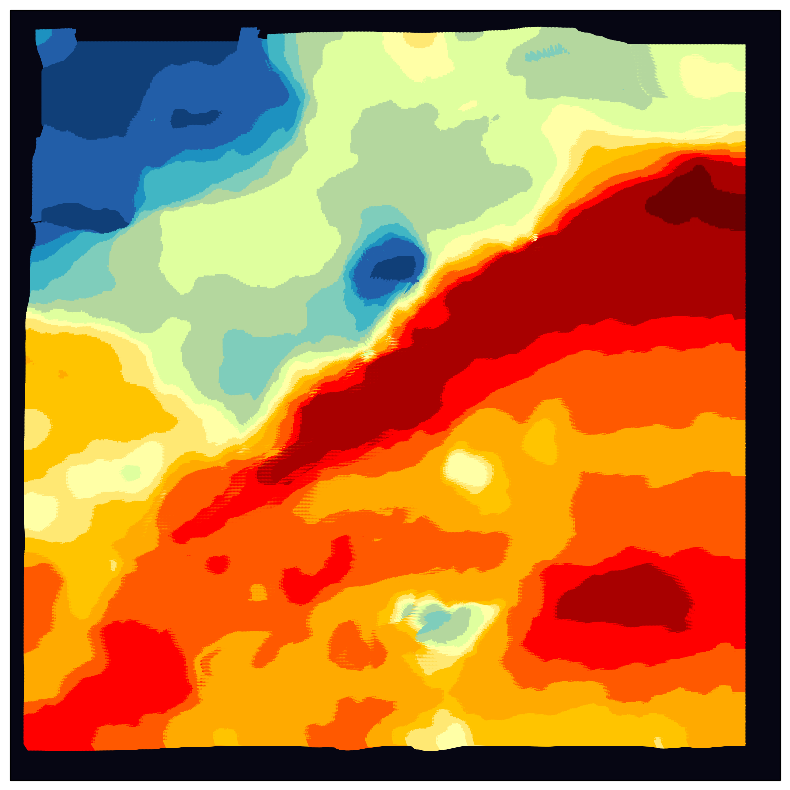

In [ ]:
# plot winds on a "PlateCarree" map
ax = common_features(dark = True, figsize = [15, 10])
ax.barbs(
    test_ds.x,
    test_ds.y,
    test_ds.U,
    test_ds.V,
    wspeed,
    **cm_wind().cmap_kwargs,
    length = 5,
)

Interesting output... might wanna look further into this...

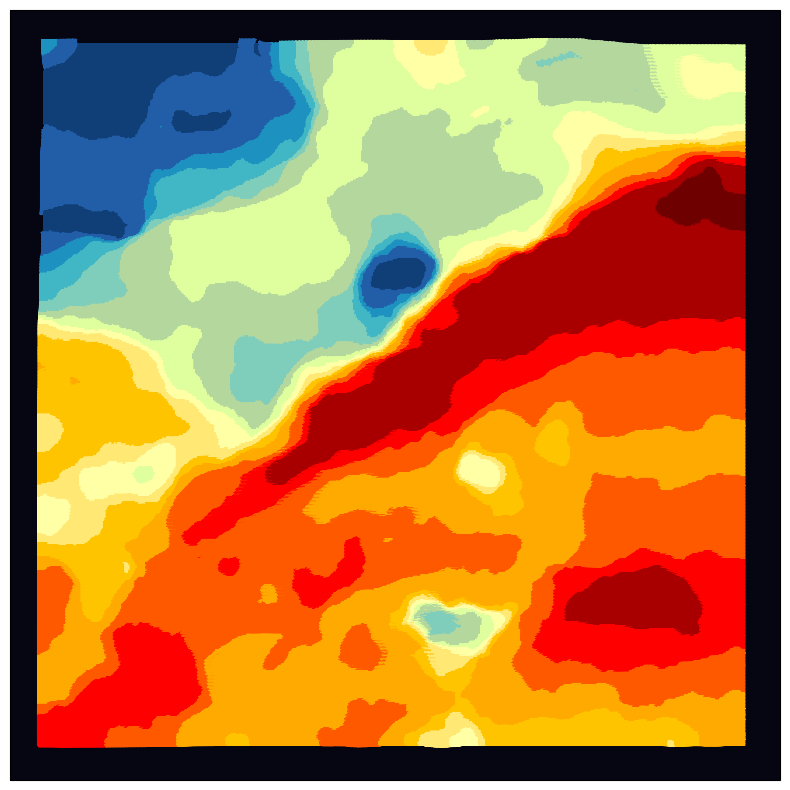

In [ ]:
# another version of the above
# plot winds on a "PlateCarree" map
ax = common_features("10m", dark = True, figsize = [15, 10], STATES = True)
ax.barbs(
    test_ds.x.data,
    test_ds.y.data,
    test_ds.U.data,
    test_ds.V.data,
    wspeed,
    **cm_wind().cmap_kwargs,
    length = 3,
    transform = pc
)

So, this didn't exactly turn out [as planned](https://github.com/blaylockbk/goes2go/blob/main/docs/user_guide/notebooks/DEMO_derived_motion_winds.ipynb), but this honestly may be best like this for use with the upcoming computer vision algorithm(s).

I still feel that using barbs is good for this, because, even though they do overlap each other, the overlap helps more concretely define problem areas, as well as the direction of winds.

Then again, **simply doing the U and V on their own would probably be more precise in terms of accounting for wind direction as well as speed.**

#### Automation

In [ ]:
# generate visualizations of AMVs for OCTANE output file
def gen_amv_visual(path_to_amv_nc):
  # load AMVs from OCTANE-out
  nc_ds = nc.Dataset(path_to_amv_nc)
  store = xr.backends.NetCDF4DataStore(nc_ds)
  amv_ds = xr.open_dataset(store)

  # calculate wind speed from U and V
  wspeed = np.sqrt(amv_ds.U ** 2 + test_ds.V ** 2)

  # plot winds on a "PlateCarree" map
  ax = common_features(dark = True, figsize = [15, 10])
  ax.barbs(
      amv_ds.x,
      amv_ds.y,
      amv_ds.U,
      amv_ds.V,
      wspeed,
      **cm_wind().cmap_kwargs,
      length = 5,
      transform = pc
  )


### RGB Compositing (OCTANE output and (soon) GLM data as well)

#### Initialization

Hoping [this](https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html#simple-image) will help a lot with making custom RGB composites

In [3]:
 # install netCDF4
 %pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.1 MB/s eta 0:00:00


In [4]:
# install earthpy
#%pip install earthpy
#%pip install satpy

In [5]:
# EarthPy and SatPy implementation (currently defunct)
# using OCTANE output U and V as R and G
#compositor = sat.composites.PaletteCompositor("palcomp")
#composite = compositor(test_ds['U'], test_ds['V'])

#### Testing

##### For this portion, we are just going to load AMVs (U --> R, V --> G, Rad -->B (using Rad as a placeholder for now))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# load AMVs from OCTANE-out
test_file_path = '/content/OCTANE-out/amvout_08-20220930042549-20220930030549.ncoutfile.nc'
nc_ds = nc.Dataset(test_file_path)
store = xr.backends.NetCDF4DataStore(nc_ds)
test_ds = xr.open_dataset(store)

FileNotFoundError: ignored

In [ ]:
# load data into R G and B variables
R = test_ds['U'].data
G = test_ds['V'].data
B = test_ds['Rad'].data

In [ ]:
# clip between 0 and 1 (RGB data can only be in that range)
# sklearn has MinMaxScaler(), which scales our data between 0 and 1 by default
print("The minimum of R is: {}".format(np.min(R)))
print("The minimum of G is: {}".format(np.min(G)))
print("The minimum of B is: {}".format(np.min(B)))
R_scaled = MinMaxScaler().fit_transform(R)
G_scaled = MinMaxScaler().fit_transform(G)
B_scaled = MinMaxScaler().fit_transform(B)
print("The minimum of R_scaled is: {}".format(np.min(R_scaled)))
print("The minimum of G_scaled is: {}".format(np.min(G_scaled)))
print("The minimum of B_scaled is: {}".format(np.min(B_scaled)))

Nice! Now, let's get a quick look at the data before composing the RGB

In [ ]:
# get a quick look at the data with plt.imshow
fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3)

# Red (U)
ax1.imshow(R_scaled, cmap = 'Reds', vmax = 1, vmin = 0)
ax1.axis('off')

# Green (V)
ax2.imshow(G_scaled, cmap = 'Greens', vmax = 1, vmin = 0)
ax2.axis('off')

# Blue (Rad)
ax3.imshow(B_scaled, cmap = 'Blues', vmax = 1, vmin = 0)
ax3.axis('off')

plt.subplots_adjust(wspace = 0.02)

Looks like we got some artifacts in the imagery...

Note to self: ensure proper cleaning of the data whenever possible.

Also, figure out optimal parameters to use with OCTANE through experimentation and analysis of the code.

Now we will combine the channels with a stacked array, and display it with `imshow`

In [ ]:
# stack the arrays
RGB = np.dstack([R_scaled, G_scaled, B_scaled])

fig, ax1 = plt.subplots(1, 1)

ax1.imshow(RGB)

Alright... so... definitely not pretty, but it's alright for now.

Aside from the (blatant) artifacts, this should be (relatively) ideal for containing the wind speeds and directions for use by the model.

#### Automation

##### Set up functions

In [10]:
# imports
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import netCDF4 as nc
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

In [11]:
# normalize data
def normalize(band):
  band_min = band.min()
  band_max = band.max()
  return ((band - band_min) / (band_max - band_min))

In [ ]:
# generate rgb composite for OCTANE output AMV file
def gen_rgb_composite(amv_file_path, filename):
  # load AMVs from OCTANE-out
  raw_ds = nc.Dataset(amv_file_path)
  stored = xr.backends.NetCDF4DataStore(raw_ds)
  curr_ds = xr.open_dataset(stored)

  # load data into R G and B variables
  Rd = curr_ds['U'].data
  Gd = curr_ds['V'].data
  Bd = curr_ds['Rad'].data

  # clip between 0 and 1 (RGB data can only be in that range)
  # sklearn has MinMaxScaler(), which scales our data between 0 and 1 by default
  Rd = normalize(Rd)
  Gd = normalize(Gd)
  Bd = normalize(Bd) #MinMaxScaler((0, 1)).fit_transform(Bd)

  # don't display the plotted figure
  matplotlib.use('Agg')

  # stack the arrays
  RGB = np.dstack([Rd, Gd, Bd])

  # get current timestep for naming conventions
  if filename:
    timestep = filename
  else:
    timestep = amv_file_path.split('_')[1][3:17]

  # plot and save composite image to appropriate directory
  #fig, ax = plt.subplots(1, 1)
  #ax.axis('off')
  #ax.im(RGB)
  #fig.savefig('/content/MPL-out/rgb-comp_{}.png'.format(timestep))
  plt.imsave('/content/MPL-out/rgb-comp_{}.png'.format(timestep), RGB, cmap='jet')
  plt.close()

In [2]:

  # path
  test_path = '1234567890/amvout-08-09-11_20220930000549_20220930003549.ncoutfile.nc'
  print(test_path[-68:-58])

234567890/


In [16]:
# this one is for test_set_5

# generate rgb composite for OCTANE output AMV file
def gen_rgb_composite(amv_file_path, filename = False):
  # get path for saving file
  save_path = os.path.join('/content/MPL-out/', amv_file_path[-68:-58])

  # load AMVs from OCTANE-out
  raw_ds = nc.Dataset(amv_file_path)
  stored = xr.backends.NetCDF4DataStore(raw_ds)
  curr_ds = xr.open_dataset(stored)

  # load data into R G and B variables
  Rd = curr_ds['U'].data
  Gd = curr_ds['V'].data
  Bd = curr_ds['Rad'].data

  # clip between 0 and 1 (RGB data can only be in that range)
  # sklearn has MinMaxScaler(), which scales our data between 0 and 1 by default
  Rd = normalize(Rd)
  Gd = normalize(Gd)
  Bd = normalize(Bd) #MinMaxScaler((0, 1)).fit_transform(Bd)

  # don't display the plotted figure
  matplotlib.use('Agg')

  # stack the arrays
  RGB = np.dstack([Rd, Gd, Bd])

  # get current timestep for naming conventions
  if filename:
    timestep = filename
  else:
    timestep = amv_file_path.split('_')[1][3:17]

  # plot and save composite image to appropriate directory
  #fig, ax = plt.subplots(1, 1)
  #ax.axis('off')
  #ax.im(RGB)
  #fig.savefig('/content/MPL-out/rgb-comp_{}.png'.format(timestep))
  plt.imsave(save_path + 'rgb-comp_{}.png'.format(timestep), RGB, cmap='jet')
  plt.close()

In [ ]:
len('amvout-08-09-11_20220930000549_20220930003549.ncoutfile.nc')

58

In [14]:
# generate rgb composites for all AMVs in directory
def gen_rgb_composites_for_dir(dir_path):
  file_names = os.listdir(dir_path)
  i = 0   # iterator
  for file in file_names:
    i += 1
    print("{}. ".format(i))
    print("Generating composite for {}...\n".format(file))
    # gen composites
    gen_rgb_composite(os.path.join(dir_path, file))
    print("Done with {}\n".format(file))
  print("Done generating RGB composites for dir {}".format(dir_path))

In [17]:
# testing
gen_rgb_composites_for_dir('/content/OCTANE-out/202209300')

1. 
Generating composite for amvout-08-09-11_20220930009549_20220930012549.ncoutfile.nc...

Done with amvout-08-09-11_20220930009549_20220930012549.ncoutfile.nc

2. 
Generating composite for amvout-08-09-11_20220930000549_20220930003549.ncoutfile.nc...

Done with amvout-08-09-11_20220930000549_20220930003549.ncoutfile.nc

3. 
Generating composite for amvout-08-09-11_20220930027549_20220930030549.ncoutfile.nc...

Done with amvout-08-09-11_20220930027549_20220930030549.ncoutfile.nc

4. 
Generating composite for amvout-08-09-11_20220930036549_20220930039549.ncoutfile.nc...

Done with amvout-08-09-11_20220930036549_20220930039549.ncoutfile.nc

5. 
Generating composite for amvout-08-09-11_20220930024549_20220930027549.ncoutfile.nc...

Done with amvout-08-09-11_20220930024549_20220930027549.ncoutfile.nc

6. 
Generating composite for amvout-08-09-11_20220930048549_20220930051549.ncoutfile.nc...

Done with amvout-08-09-11_20220930048549_20220930051549.ncoutfile.nc

7. 
Generating composite for

In [22]:
!rm -r MPL-out/*

In [24]:
# specifically for test_set_5
def gen_rgb_composites_for_subdirs(base_dir):
  # get sub directory list
  sub_dirs = os.listdir(base_dir)
  # create folders, gen composites for dir
  for dir in sub_dirs:
    # create folder for day/hour
    os.mkdir(os.path.join("/content/MPL-out/", dir))
    # gen for all in dir
    gen_rgb_composites_for_dir(base_dir + '/' + dir)

In [26]:
# gen composites for test_set_5
gen_rgb_composites_for_subdirs('/content/OCTANE-out')

1. 
Generating composite for amvout-08-09-11_20220952345549_20220952348549.ncoutfile.nc...

Done with amvout-08-09-11_20220952345549_20220952348549.ncoutfile.nc

2. 
Generating composite for amvout-08-09-11_20220952318549_20220952321549.ncoutfile.nc...

Done with amvout-08-09-11_20220952318549_20220952321549.ncoutfile.nc

3. 
Generating composite for amvout-08-09-11_20220952348549_20220952351549.ncoutfile.nc...

Done with amvout-08-09-11_20220952348549_20220952351549.ncoutfile.nc

4. 
Generating composite for amvout-08-09-11_20220952330549_20220952333549.ncoutfile.nc...

Done with amvout-08-09-11_20220952330549_20220952333549.ncoutfile.nc

5. 
Generating composite for amvout-08-09-11_20220952315549_20220952318549.ncoutfile.nc...

Done with amvout-08-09-11_20220952315549_20220952318549.ncoutfile.nc

6. 
Generating composite for amvout-08-09-11_20220952300549_20220952303549.ncoutfile.nc...

Done with amvout-08-09-11_20220952300549_20220952303549.ncoutfile.nc

7. 
Generating composite for

<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))
<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220932124549_20220932127549.ncoutfile.nc

2. 
Generating composite for amvout-08-09-11_20220932142549_20220932145549.ncoutfile.nc...

Done with amvout-08-09-11_20220932142549_20220932145549.ncoutfile.nc

3. 
Generating composite for amvout-08-09-11_20220932133549_20220932136549.ncoutfile.nc...

Done with amvout-08-09-11_20220932133549_20220932136549.ncoutfile.nc

4. 
Generating composite for amvout-08-09-11_20220932130549_20220932133549.ncoutfile.nc...

Done with amvout-08-09-11_20220932130549_20220932133549.ncoutfile.nc

5. 
Generating composite for amvout-08-09-11_20220932148549_20220932151549.ncoutfile.nc...



<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220932148549_20220932151549.ncoutfile.nc

6. 
Generating composite for amvout-08-09-11_20220932109549_20220932112549.ncoutfile.nc...

Done with amvout-08-09-11_20220932109549_20220932112549.ncoutfile.nc

7. 
Generating composite for amvout-08-09-11_20220932145549_20220932148549.ncoutfile.nc...

Done with amvout-08-09-11_20220932145549_20220932148549.ncoutfile.nc

8. 
Generating composite for amvout-08-09-11_20220932151549_20220932154549.ncoutfile.nc...



<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220932151549_20220932154549.ncoutfile.nc

9. 
Generating composite for amvout-08-09-11_20220932115549_20220932118549.ncoutfile.nc...

Done with amvout-08-09-11_20220932115549_20220932118549.ncoutfile.nc

10. 
Generating composite for amvout-08-09-11_20220932103549_20220932106549.ncoutfile.nc...

Done with amvout-08-09-11_20220932103549_20220932106549.ncoutfile.nc

11. 
Generating composite for amvout-08-09-11_20220932112549_20220932115549.ncoutfile.nc...

Done with amvout-08-09-11_20220932112549_20220932115549.ncoutfile.nc

12. 
Generating composite for amvout-08-09-11_20220932106549_20220932109549.ncoutfile.nc...

Done with amvout-08-09-11_20220932106549_20220932109549.ncoutfile.nc

13. 
Generating composite for amvout-08-09-11_20220932100549_20220932103549.ncoutfile.nc...

Done with amvout-08-09-11_20220932100549_20220932103549.ncoutfile.nc

14. 
Generating composite for amvout-08-09-11_20220932127549_20220932130549.ncoutfile.nc...



<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))
<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220932127549_20220932130549.ncoutfile.nc

15. 
Generating composite for amvout-08-09-11_20220932139549_20220932142549.ncoutfile.nc...

Done with amvout-08-09-11_20220932139549_20220932142549.ncoutfile.nc

16. 
Generating composite for amvout-08-09-11_20220932136549_20220932139549.ncoutfile.nc...

Done with amvout-08-09-11_20220932136549_20220932139549.ncoutfile.nc

17. 
Generating composite for amvout-08-09-11_20220932118549_20220932121549.ncoutfile.nc...

Done with amvout-08-09-11_20220932118549_20220932121549.ncoutfile.nc

18. 
Generating composite for amvout-08-09-11_20220932121549_20220932124549.ncoutfile.nc...

Done with amvout-08-09-11_20220932121549_20220932124549.ncoutfile.nc

Done generating RGB composites for dir /content/OCTANE-out/202209321
1. 
Generating composite for amvout-08-09-11_20220951304549_20220951307549.ncoutfile.nc...



<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))
<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220951304549_20220951307549.ncoutfile.nc

2. 
Generating composite for amvout-08-09-11_20220951319549_20220951322549.ncoutfile.nc...

Done with amvout-08-09-11_20220951319549_20220951322549.ncoutfile.nc

3. 
Generating composite for amvout-08-09-11_20220951343549_20220951346549.ncoutfile.nc...

Done with amvout-08-09-11_20220951343549_20220951346549.ncoutfile.nc

4. 
Generating composite for amvout-08-09-11_20220951316549_20220951319549.ncoutfile.nc...

Done with amvout-08-09-11_20220951316549_20220951319549.ncoutfile.nc

5. 
Generating composite for amvout-08-09-11_20220951322549_20220951325549.ncoutfile.nc...

Done with amvout-08-09-11_20220951322549_20220951325549.ncoutfile.nc

6. 
Generating composite for amvout-08-09-11_20220951301549_20220951304549.ncoutfile.nc...

Done with amvout-08-09-11_20220951301549_20220951304549.ncoutfile.nc

7. 
Generating composite for amvout-08-09-11_20220951307549_20220951310549.ncoutfile.nc...

Done with amvout-08-09-11_20

<ipython-input-11-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout-08-09-11_20220970446565_20220970449570.ncoutfile.nc

4. 
Generating composite for amvout-08-09-11_20220970434549_20220970437549.ncoutfile.nc...

Done with amvout-08-09-11_20220970434549_20220970437549.ncoutfile.nc

5. 
Generating composite for amvout-08-09-11_20220970401549_20220970404549.ncoutfile.nc...

Done with amvout-08-09-11_20220970401549_20220970404549.ncoutfile.nc

6. 
Generating composite for amvout-08-09-11_20220970443559_20220970446565.ncoutfile.nc...

Done with amvout-08-09-11_20220970443559_20220970446565.ncoutfile.nc

7. 
Generating composite for amvout-08-09-11_20220970431549_20220970434549.ncoutfile.nc...

Done with amvout-08-09-11_20220970431549_20220970434549.ncoutfile.nc

8. 
Generating composite for amvout-08-09-11_20220970407549_20220970410549.ncoutfile.nc...

Done with amvout-08-09-11_20220970407549_20220970410549.ncoutfile.nc

9. 
Generating composite for amvout-08-09-11_20220970422549_20220970425549.ncoutfile.nc...

Done with amvout-08-09-11_20

In [27]:
# zip the file for download
!zip MPL-out_ts5.zip /content/MPL-out/*/*

  adding: content/MPL-out/202209300/rgb-comp_20930000549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930003549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930006549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930009549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930012549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930015549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930018549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930021549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930024549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930027549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930030549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930033549.png (deflated 0%)
  adding: content/MPL-out/202209300/rgb-comp_20930036549.png (deflated 0%)
  adding: content/MPL-out

In [28]:
!cp ./MPL-out_ts5.zip /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/dataset/test_set_5

In [6]:
!7z x ./OCTANE-out_ts5.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./            1 file, 445644800 bytes (425 MiB)

Extracting archive: ./OCTANE-out_ts5.zip
 48% 256 Open             
ERRORS:
Unexpected end of archive

--
Path = ./OCTANE-out_ts5.zip
Type = zip
ERRORS:
Unexpected end of archive
Physical Size = 445879332

 16%      0% 3 - OCTANE-out/202209300/amvout-08- . 549_20220930012549.ncoutfile.nc                                                                            1% 5 - OCTANE-out/202209300/amvout-08- . 549_20220930018549.ncoutfile.nc

##### Use functions

In [ ]:
# generate composites for files in /content/OCTANE-out
gen_rgb_composites_for_dir('/content/OCTANE-out')

1. 
Generating composite for amvout_08-20220961848549-20220961812549.ncoutfile.nc...

Done with amvout_08-20220961848549-20220961812549.ncoutfile.nc

2. 
Generating composite for amvout_08-20220931710549-20220931704549.ncoutfile.nc...

Done with amvout_08-20220931710549-20220931704549.ncoutfile.nc

3. 
Generating composite for amvout_08-20220962215549-20220962218549.ncoutfile.nc...

Done with amvout_08-20220962215549-20220962218549.ncoutfile.nc

4. 
Generating composite for amvout_08-20220941927549-20220941918549.ncoutfile.nc...

Done with amvout_08-20220941927549-20220941918549.ncoutfile.nc

5. 
Generating composite for amvout_08-20220960320549-20220960332549.ncoutfile.nc...

Done with amvout_08-20220960320549-20220960332549.ncoutfile.nc

6. 
Generating composite for amvout_08-20220970049549-20220970052549.ncoutfile.nc...

Done with amvout_08-20220970049549-20220970052549.ncoutfile.nc

7. 
Generating composite for amvout_08-20220940219549-20220940246549.ncoutfile.nc...

Done with amvo

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220950825549-20220950840549.ncoutfile.nc

17. 
Generating composite for amvout_08-20220961300549-20220961325549.ncoutfile.nc...

Done with amvout_08-20220961300549-20220961325549.ncoutfile.nc

18. 
Generating composite for amvout_08-20220961035549-20220961023549.ncoutfile.nc...

Done with amvout_08-20220961035549-20220961023549.ncoutfile.nc

19. 
Generating composite for amvout_08-20220940637549-20220940619549.ncoutfile.nc...

Done with amvout_08-20220940637549-20220940619549.ncoutfile.nc

20. 
Generating composite for amvout_08-20220941418549-20220941436549.ncoutfile.nc...

Done with amvout_08-20220941418549-20220941436549.ncoutfile.nc

21. 
Generating composite for amvout_08-20220931112549-20220931151549.ncoutfile.nc...

Done with amvout_08-20220931112549-20220931151549.ncoutfile.nc

22. 
Generating composite for amvout_08-20220931106549-20220931109549.ncoutfile.nc...

Done with amvout_08-20220931106549-20220931109549.ncoutfile.nc

23. 
Generating composite for 

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220932124549-20220932121549.ncoutfile.nc

55. 
Generating composite for amvout_08-20220961809549-20220961839549.ncoutfile.nc...

Done with amvout_08-20220961809549-20220961839549.ncoutfile.nc

56. 
Generating composite for amvout_08-20220950822549-20220950843549.ncoutfile.nc...

Done with amvout_08-20220950822549-20220950843549.ncoutfile.nc

57. 
Generating composite for amvout_08-20220941146549-20220941149549.ncoutfile.nc...

Done with amvout_08-20220941146549-20220941149549.ncoutfile.nc

58. 
Generating composite for amvout_08-20220930054549-20220930021549.ncoutfile.nc...

Done with amvout_08-20220930054549-20220930021549.ncoutfile.nc

59. 
Generating composite for amvout_08-20220942240549-20220942201549.ncoutfile.nc...

Done with amvout_08-20220942240549-20220942201549.ncoutfile.nc

60. 
Generating composite for amvout_08-20220962046549-20220962001549.ncoutfile.nc...

Done with amvout_08-20220962046549-20220962001549.ncoutfile.nc

61. 
Generating composite for 

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220942222549-20220942213549.ncoutfile.nc

142. 
Generating composite for amvout_08-20220951651549-20220951621549.ncoutfile.nc...

Done with amvout_08-20220951651549-20220951621549.ncoutfile.nc

143. 
Generating composite for amvout_08-20220961026549-20220961011549.ncoutfile.nc...

Done with amvout_08-20220961026549-20220961011549.ncoutfile.nc

144. 
Generating composite for amvout_08-20220930554549-20220930530549.ncoutfile.nc...

Done with amvout_08-20220930554549-20220930530549.ncoutfile.nc

145. 
Generating composite for amvout_08-20220951642549-20220951633549.ncoutfile.nc...

Done with amvout_08-20220951642549-20220951633549.ncoutfile.nc

146. 
Generating composite for amvout_08-20220961002549-20220961014549.ncoutfile.nc...

Done with amvout_08-20220961002549-20220961014549.ncoutfile.nc

147. 
Generating composite for amvout_08-20220952345549-20220952327549.ncoutfile.nc...

Done with amvout_08-20220952345549-20220952327549.ncoutfile.nc

148. 
Generating composi

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220930524549-20220930503549.ncoutfile.nc

153. 
Generating composite for amvout_08-20220960302549-20220960305549.ncoutfile.nc...

Done with amvout_08-20220960302549-20220960305549.ncoutfile.nc

154. 
Generating composite for amvout_08-20220941439549-20220941424549.ncoutfile.nc...

Done with amvout_08-20220941439549-20220941424549.ncoutfile.nc

155. 
Generating composite for amvout_08-20220952043549-20220952031549.ncoutfile.nc...

Done with amvout_08-20220952043549-20220952031549.ncoutfile.nc

156. 
Generating composite for amvout_08-20220961306549-20220961303549.ncoutfile.nc...

Done with amvout_08-20220961306549-20220961303549.ncoutfile.nc

157. 
Generating composite for amvout_08-20220961316549-20220961331549.ncoutfile.nc...

Done with amvout_08-20220961316549-20220961331549.ncoutfile.nc

158. 
Generating composite for amvout_08-20220940207549-20220940204549.ncoutfile.nc...

Done with amvout_08-20220940207549-20220940204549.ncoutfile.nc

159. 
Generating composi

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220932136549-20220932112549.ncoutfile.nc

231. 
Generating composite for amvout_08-20220952001549-20220952010549.ncoutfile.nc...

Done with amvout_08-20220952001549-20220952010549.ncoutfile.nc

232. 
Generating composite for amvout_08-20220932310549-20220932334549.ncoutfile.nc...

Done with amvout_08-20220932310549-20220932334549.ncoutfile.nc

233. 
Generating composite for amvout_08-20220942246549-20220942210549.ncoutfile.nc...

Done with amvout_08-20220942246549-20220942210549.ncoutfile.nc

234. 
Generating composite for amvout_08-20220931755549-20220931734549.ncoutfile.nc...

Done with amvout_08-20220931755549-20220931734549.ncoutfile.nc

235. 
Generating composite for amvout_08-20220960311549-20220960329549.ncoutfile.nc...

Done with amvout_08-20220960311549-20220960329549.ncoutfile.nc

236. 
Generating composite for amvout_08-20220952354549-20220952318549.ncoutfile.nc...

Done with amvout_08-20220952354549-20220952318549.ncoutfile.nc

237. 
Generating composi

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))
<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220932112549-20220932124549.ncoutfile.nc

321. 
Generating composite for amvout_08-20220932307549-20220932313549.ncoutfile.nc...

Done with amvout_08-20220932307549-20220932313549.ncoutfile.nc

322. 
Generating composite for amvout_08-20220941116549-20220941122549.ncoutfile.nc...

Done with amvout_08-20220941116549-20220941122549.ncoutfile.nc

323. 
Generating composite for amvout_08-20220940255549-20220940210549.ncoutfile.nc...

Done with amvout_08-20220940255549-20220940210549.ncoutfile.nc

324. 
Generating composite for amvout_08-20220931740549-20220931725549.ncoutfile.nc...

Done with amvout_08-20220931740549-20220931725549.ncoutfile.nc

325. 
Generating composite for amvout_08-20220931746549-20220931737549.ncoutfile.nc...

Done with amvout_08-20220931746549-20220931737549.ncoutfile.nc

326. 
Generating composite for amvout_08-20220950410549-20220950455549.ncoutfile.nc...

Done with amvout_08-20220950410549-20220950455549.ncoutfile.nc

327. 
Generating composi

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220950440555-20220950422549.ncoutfile.nc

385. 
Generating composite for amvout_08-20220951322549-20220951310549.ncoutfile.nc...

Done with amvout_08-20220951322549-20220951310549.ncoutfile.nc

386. 
Generating composite for amvout_08-20220931109549-20220931100549.ncoutfile.nc...

Done with amvout_08-20220931109549-20220931100549.ncoutfile.nc

387. 
Generating composite for amvout_08-20220962031549-20220962037549.ncoutfile.nc...

Done with amvout_08-20220962031549-20220962037549.ncoutfile.nc

388. 
Generating composite for amvout_08-20220930057549-20220930033549.ncoutfile.nc...

Done with amvout_08-20220930057549-20220930033549.ncoutfile.nc

389. 
Generating composite for amvout_08-20220952333549-20220952345549.ncoutfile.nc...

Done with amvout_08-20220952333549-20220952345549.ncoutfile.nc

390. 
Generating composite for amvout_08-20220931115549-20220931124549.ncoutfile.nc...

Done with amvout_08-20220931115549-20220931124549.ncoutfile.nc

391. 
Generating composi

<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220961857549-20220961851549.ncoutfile.nc

406. 
Generating composite for amvout_08-20220932133549-20220932148549.ncoutfile.nc...

Done with amvout_08-20220932133549-20220932148549.ncoutfile.nc

407. 
Generating composite for amvout_08-20220942249549-20220942231549.ncoutfile.nc...



<ipython-input-153-aeba5e6b02df>:5: RuntimeWarning: invalid value encountered in true_divide
  return ((band - band_min) / (band_max - band_min))


Done with amvout_08-20220942249549-20220942231549.ncoutfile.nc

408. 
Generating composite for amvout_08-20220952040549-20220952004549.ncoutfile.nc...

Done with amvout_08-20220952040549-20220952004549.ncoutfile.nc

409. 
Generating composite for amvout_08-20220930518549-20220930554549.ncoutfile.nc...

Done with amvout_08-20220930518549-20220930554549.ncoutfile.nc

410. 
Generating composite for amvout_08-20220941900549-20220941930549.ncoutfile.nc...

Done with amvout_08-20220941900549-20220941930549.ncoutfile.nc

411. 
Generating composite for amvout_08-20220961041549-20220961017549.ncoutfile.nc...

Done with amvout_08-20220961041549-20220961017549.ncoutfile.nc

412. 
Generating composite for amvout_08-20220952339549-20220952306549.ncoutfile.nc...

Done with amvout_08-20220952339549-20220952306549.ncoutfile.nc

413. 
Generating composite for amvout_08-20220941128549-20220941125549.ncoutfile.nc...

Done with amvout_08-20220941128549-20220941125549.ncoutfile.nc

414. 
Generating composi

In [ ]:
# zip up the MPL-out directory for saving to local filesystem
!zip -r MPL-out.zip ./MPL-out/*

  adding: MPL-out/rgb-comp_20220930000549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930003549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930006549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930009549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930012549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930015549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930018549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930021549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930024549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930030549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930033549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930036549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930039549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930042549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930045549.png (deflated 0%)
  adding: MPL-out/rgb-comp_20220930048549.png (deflated 0%)
  adding: MPL-out/rgb-comp_2022093005154

In [ ]:
!rm -r ./MPL-out/*
!rm -r ./OCTANE-out/.ipynb_checkpoints

rm: cannot remove './MPL-out/*': No such file or directory


## MS-LSTM/MS-RNN Implementation:

#### Initialization (from Github repo):

Utilizing resources from the [MS-RNN Github repo](https://github.com/mazhf/MS-RNN/tree/main)

Important note: considering the limitations of free Google Colab, I am going to be doing initial experimentation on my own hardware (despite the limitations of not having a NVIDIA GPU currently accessible to me)

In [ ]:
# clone github repo
!git clone https://github.com/mazhf/MS-RNN.git

Cloning into 'MS-RNN'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 244 (delta 42), reused 14 (delta 14), pack-reused 155
Receiving objects: 100% (244/244), 6.07 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [1]:
# install libraries, as per the included README
!pip3 install -r ./MS-RNN/requirements.txt --extra-index-url https://download.pytorch.org/whl/cu113

ERROR: Could not open requirements file: [Errno 2] No such file or directory: './MS-RNN/requirements.txt'


In [ ]:
# installing local attention (only needed for PrecipLSTM/MS-PrecipLSTM):
!cd ./MS-RNN/img_local_att && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

#### Initialization (from customized version of MS-RNN repo):

In [1]:
!unzip MS-RNN_experimenting.zip

Archive:  MS-RNN_experimenting.zip
   creating: MS-RNN_experimenting/__pycache__/
  inflating: MS-RNN_experimenting/__pycache__/config.cpython-310.pyc  
  inflating: MS-RNN_experimenting/__pycache__/loss.cpython-310.pyc  
  inflating: MS-RNN_experimenting/__pycache__/main.cpython-310.pyc  
  inflating: MS-RNN_experimenting/__pycache__/model.cpython-310.pyc  
  inflating: MS-RNN_experimenting/__pycache__/net_params.cpython-310.pyc  
  inflating: MS-RNN_experimenting/__pycache__/train_and_test.cpython-310.pyc  
  inflating: MS-RNN_experimenting/config.py  
  inflating: MS-RNN_experimenting/config_default.py  
   creating: MS-RNN_experimenting/img_local_att/
   creating: MS-RNN_experimenting/img_local_att/__pycache__/
  inflating: MS-RNN_experimenting/img_local_att/__pycache__/function.cpython-310.pyc  
   creating: MS-RNN_experimenting/img_local_att/build/
   creating: MS-RNN_experimenting/img_local_att/build/lib.linux-x86_64-3.7/
  inflating: MS-RNN_experimenting/img_local_att/build/lib

In [2]:
# install libraries, as per the included README
!pip3 install -r ./MS-RNN_experimenting/requirements.txt --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 947.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 20.9 MB/s eta 0:00:00
  Created wheel for h5py: filename=h5py-2.9.0-cp310-cp310-linux_x86_64.whl size=4619138 sha256=1b427458e404037571a62dc797f5edd916755641333cd267d76244e9b6ffafc3
  Stored in directory: /root/.cache/pip/wheels/c0/d9/a1/5c4603e22344ca647a552d8c4e2f773d18026242ffff835520
Successfully built h5py
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting u

In [3]:
# installing local attention (only needed for PrecipLSTM/MS-PrecipLSTM):
!cd ./MS-RNN_experimenting/img_local_att && python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

#### KTH-Action dataset


In [ ]:
# a couple of preprocessing things to take care of first
# basically just copying custom versions of the MS-RNN files to the local installation
!cp '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/MS-RNN/config.py' ./MS-RNN/config.py
!cp '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/MS-RNN/util/kth_preproccess.py' ./MS-RNN/util/kth_preproccess.py
!cp '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/dataset/kth_txt/test_data_list_trimmed_only_run.txt' ./dataset/kth_txt/test_data_list_trimmed_only_run.txt
!cp '/content/drive/MyDrive/Colab Notebooks/tornado-forecasting/dataset/kth_txt/train_data_list_trimmed_only_run.txt' ./dataset/kth_txt/train_data_list_trimmed_only_run.txt

In [ ]:
# NO LONGER NEEDED (kept as reference)
# move files to proper folders (from ./kth to ./kth/<action>)
os.chdir('/content/dataset/kth')
#!find . -maxdepth 1 -type f -name '*jogging*' -exec mv {} ./jogging/{} \;
#!find . -maxdepth 1 -type f -name '*running*' -exec mv {} ./running/{} \;
#!find . -maxdepth 1 -type f -name '*walking*' -exec mv {} ./walking/{} \;
os.chdir('/content')

In [ ]:
# preprocess kth data for use in main program
# (generates .png sequences from .avi video files)

import os

os.chdir('/content/MS-RNN')

from util.kth_preproccess import avi2png

avi2png('/content/dataset/kth', '/content/dataset/kth_160_png')

视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person05_walking_d1
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person07_walking_d2
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person17_walking_d1
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person17_walking_d2
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person13_walking_d2
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person21_walking_d3
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walking/person13_walking_d1
************************************************
视频读取成功，正在逐帧截取...
截取完成，图像保存在：/content/dataset/kth_160_png/walki

In [ ]:
!cp -r /content/dataset/kth_160_png/running/* /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/dataset/kth_160_png/running/
!cp -r /content/dataset/kth_160_png/walking/* /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/dataset/kth_160_png/walking/

#### Custom dataset `GOES-ABI_test-set-5` setup:

In [7]:
!mkdir dataset
!7z x GOES-ABI_test-set-5.zip -o/content/dataset/

mkdir: cannot create directory ‘dataset’: File exists

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 100794236 bytes (97 MiB)

Extracting archive: GOES-ABI_test-set-5.zip
--
Path = GOES-ABI_test-set-5.zip
Type = zip
Physical Size = 100794236

  0%    
Would you like to replace the existing file:
  Path:     /content/dataset/GOES-ABI_test-set-5/file_lists/test_data_list.txt
  Size:     153 bytes (1 KiB)
  Modified: 2023-07-27 12:51:08
with the file from archive:
  Path:     GOES-ABI_test-set-5/file_lists/test_data_list.txt
  Size:     153 bytes (1 KiB)
  Modified: 2023-07-27 12:51:08
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

#### Running the model

In [4]:
import os

In [30]:
# run the model
os.chdir('/content')
!python -m torch.distributed.launch ./MS-RNN_experimenting/main.py

/usr/local/lib/python3.10/dist-packages/torch/distributed/launch.py:178: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
2.6105524230603074
This is MS-LSTM!
local_rank:  0
Total sequences: 90
Total "videos" (in this case, days): 15
Total sequences: 42
Total "videos" (in this case, days): 7
epoch:  1
train_batch:   0% 0/23 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/content/./MS-RNN_experimenting/main.py", line 84, in <module>
    train_and_test(model, optimizer, criterion, train_epoch, valid_epoch, loader, train_sampler)
  File "/content/MS-RNN_experimenting/train_and_test.py", line 76, in train_and_test
    train_pred, decoup

In [37]:
# run the model
os.chdir('/content')
!python -m torch.distributed.launch ./MS-RNN_experimenting/main.py

/usr/local/lib/python3.10/dist-packages/torch/distributed/launch.py:178: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
2.6105524230603074
This is MS-ConvLSTM!
local_rank:  0
Total sequences: 90
Total "videos" (in this case, days): 15
Total sequences: 42
Total "videos" (in this case, days): 7
epoch:  1
train_batch:   0% 0/23 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/content/./MS-RNN_experimenting/main.py", line 84, in <module>
    train_and_test(model, optimizer, criterion, train_epoch, valid_epoch, loader, train_sampler)
  File "/content/MS-RNN_experimenting/train_and_test.py", line 76, in train_and_test
    train_pred, de

In [36]:
!zip -r MS-ConvLSTM_ts5_out.zip ./MS-RNN_experimenting/save
!cp MS-ConvLSTM_ts5_out.zip /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/

  adding: MS-RNN_experimenting/save/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/truth_pred.avi (deflated 6%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/truth.avi (deflated 9%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/pred.avi (deflated 12%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/pred_img/ (stored 0%)
  adding: MS-RNN_experimenting/save/GOES-ABI_test-set-5/MS-ConvLSTM/demo/random_seed_1_demo/pred_img/6.png (deflated 21%)
  adding: MS-RNN_expe

In [ ]:
# copy results to drive for download and analysis
!cp -r ./MS-RNN_experimenting/save/* /content/drive/MyDrive/Colab\ Notebooks/tornado-forecasting/MS-RNN/save/